---


**Датасет соревнования:** https://www.kaggle.com/competitions/sberbank-russian-housing-market/data


**Описание:**

Housing costs demand a significant investment from both consumers and developers. And when it comes to planning a budget—whether personal or corporate—the last thing anyone needs is uncertainty about one of their biggets expenses. Sberbank, Russia’s oldest and largest bank, helps their customers by making predictions about realty prices so renters, developers, and lenders are more confident when they sign a lease or purchase a building.

Although the housing market is relatively stable in Russia, the country’s volatile economy makes forecasting prices as a function of apartment characteristics a unique challenge. Complex interactions between housing features such as number of bedrooms and location are enough to make pricing predictions complicated. Adding an unstable economy to the mix means Sberbank and their customers need more than simple regression models in their arsenal.

In this competition, Sberbank is challenging Kagglers to develop algorithms which use a broad spectrum of features to predict realty prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.

<br><br>
**Цели:** 
  <ul><li>Быстро познакомиться с датасетом</li> 
  <li>Быстро провести вводный анализ признаков</li>


---

# Содержание:

1. [Работа с библиотеками](#c1)
2. [Загрузка датасета](#c3)
3. [ИАД](#c4)
4. [Итоги обзора:](#c5)

<a name="c1"></a>
#Работа с библиотеками

In [8]:
!pip install outlier_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импорты:

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats as st
from outliers import smirnov_grubbs as grubbs

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
sns.set_palette("Paired")

<a name="c2"></a>
# Загрузка датасета

Будем считать, что ZIP-файл для работы был уже скачан **участником соревнования**.

Разархивируем файл:

In [10]:
!mkdir datasets
!unzip /content/sberbank-russian-housing-market.zip -d datasets
!dir datasets

mkdir: cannot create directory ‘datasets’: File exists
Archive:  /content/sberbank-russian-housing-market.zip
  inflating: datasets/data_dictionary.txt  
  inflating: datasets/macro.csv.zip  
  inflating: datasets/sample_submission.csv.zip  
  inflating: datasets/test.csv.zip   
  inflating: datasets/train.csv.zip  
data_dictionary.txt  sample_submission.csv.zip	train.csv.zip
macro.csv.zip	     test.csv.zip


In [187]:
!unzip datasets/train.csv.zip -d datasets

Archive:  datasets/train.csv.zip
replace datasets/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [215]:
path1 = "../input/traint/train.csv"
path2 = "/content/datasets/train.csv"

if os.path.exists(path1):
    data = pd.read_csv(path1)
elif os.path.exists(path2):
    data = pd.read_csv(path2)
else:
    print("We have a problem")

<a name="c4"></a>
# ИАД

Для работы будут использоваться признаки, относящиеся конкретно к объекту недвижимости (см. описание), а также особенности окружающего района каждого объекта недвижимости. 

Общий список признаков:

**trc_**: shopping malls

**prom_**: industrial zones

**green_**: green zones

**metro_**: subway

**_avto_**: distances by car

**mkad_**: Moscow Circle Auto Road

**ttk_**: Third Transport Ring

**sadovoe_**: Garden Ring

**bulvar_ring_**: Boulevard Ring

**kremlin_**: City center

**zd_vokzaly_**: Train station

**oil_chemistry_**: Dirty industry

**ts_**: Power plant

**price_doc**: sale price (this is the target variable)

**timestamp**: date of transaction

**full_sq**: total area in square meters, including loggias, balconies 
and other non-residential areas

**life_sq**: living area in square meters, excluding loggias, balconies and other non-residential areas

**floor**: for apartments, floor of the building

**max_floor**: number of floors in the building

**material**: wall material

**build_year**: year built

**num_room**: number of living rooms

**kitch_sq**: kitchen area

**state**: apartment condition

**product_type**: owner-occupier purchase or investment

**sub_area**: name of the district
<br><br>

Возьмём Москву с радиусом ~25 км


In [216]:
columns = [
           'trc_count_1500', 'prom_part_1500', 'green_part_1500', 'metro_km_walk', 'mkad_km',
           'sadovoe_km', 'kremlin_km', 'oil_chemistry_km',
           'timestamp', 'full_sq', 'life_sq', 'floor',
           'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state',
           'product_type', 'sub_area', 'price_doc'
           ]

In [217]:
data = data[columns].loc[data['kremlin_km'] < 26]

In [218]:
data.shape

(27503, 21)

Посмотрим первые 5 записей:

In [219]:
data.head()

,trc_count_1500,prom_part_1500,green_part_1500,metro_km_walk,mkad_km,sadovoe_km,kremlin_km,oil_chemistry_km,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
0,9,6.9200,14.2700,1.1313,1.4224,13.1006,15.1562,18.1523,2011-08-20,43,27.0000,4.0000,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,5850000
1,7,7.7100,21.5300,0.6351,9.5034,6.4443,8.6981,9.0346,2011-08-23,34,19.0000,3.0000,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,6000000
2,1,6.7300,9.9200,1.4460,5.6048,6.9634,9.0679,5.7774,2011-08-27,43,29.0000,2.0000,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,5700000
3,7,6.5700,28.3800,0.9638,2.6778,17.4572,19.4870,27.6679,2011-09-01,89,50.0000,9.0000,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,13100000
4,9,4.8300,4.1200,0.6889,11.6167,0.0468,2.5787,6.5159,2011-09-05,77,77.0000,4.0000,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,16331452


Общая информация о столбцах:

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27503 entries, 0 to 30470
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trc_count_1500    27503 non-null  int64  
 1   prom_part_1500    27503 non-null  float64
 2   green_part_1500   27503 non-null  float64
 3   metro_km_walk     27478 non-null  float64
 4   mkad_km           27503 non-null  float64
 5   sadovoe_km        27503 non-null  float64
 6   kremlin_km        27503 non-null  float64
 7   oil_chemistry_km  27503 non-null  float64
 8   timestamp         27503 non-null  object 
 9   full_sq           27503 non-null  int64  
 10  life_sq           22106 non-null  float64
 11  floor             27379 non-null  float64
 12  max_floor         18635 non-null  float64
 13  material          18635 non-null  float64
 14  build_year        15368 non-null  float64
 15  num_room          18635 non-null  float64
 16  kitch_sq          18635 non-null  float6

In [221]:
data.isna().mean() * 100

trc_count_1500      0.0000
prom_part_1500      0.0000
green_part_1500     0.0000
metro_km_walk       0.0909
mkad_km             0.0000
sadovoe_km          0.0000
kremlin_km          0.0000
oil_chemistry_km    0.0000
timestamp           0.0000
full_sq             0.0000
life_sq            19.6233
floor               0.4509
max_floor          32.2438
material           32.2438
build_year         44.1225
num_room           32.2438
kitch_sq           32.2438
state              44.3043
product_type        0.0000
sub_area            0.0000
price_doc           0.0000
dtype: float64

In [222]:
data.describe()

,trc_count_1500,prom_part_1500,green_part_1500,metro_km_walk,mkad_km,sadovoe_km,kremlin_km,oil_chemistry_km,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
count,27503.0000,27503.0000,27503.0000,27478.0000,27503.0000,27503.0000,27503.0000,27503.0000,27503.0000,22106.0000,27379.0000,18635.0000,18635.0000,15368.0000,18635.0000,18635.0000,15318.0000,27503.0000
mean,4.0505,10.9992,18.6661,2.0570,5.2047,12.1601,14.1493,15.3285,54.1147,34.0617,7.7916,12.7733,1.8089,3198.4485,1.9254,6.4788,2.1506,7391404.5064
std,4.5891,11.3026,13.1034,1.6895,3.3433,5.8708,6.0268,8.0596,39.1448,54.0968,5.3808,6.7235,1.4527,161737.0899,0.8542,26.1400,0.8678,4910286.3894
min,0.0000,0.0000,0.0000,0.0000,0.0136,0.0004,0.0729,0.5107,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,100000.0000
25%,1.0000,1.4500,8.8850,0.8864,2.4983,7.8028,9.8951,8.4834,38.0000,20.0000,3.0000,9.0000,1.0000,1966.0000,1.0000,1.0000,1.0000,5000000.0000
50%,3.0000,7.9500,14.8300,1.5162,4.6696,11.6917,13.8125,14.8339,49.0000,30.0000,7.0000,12.0000,1.0000,1978.0000,2.0000,6.0000,2.0000,6450000.0000
75%,6.0000,16.4900,26.4600,2.4369,7.4660,17.4890,19.5253,21.9045,63.0000,43.0000,11.0000,17.0000,2.0000,2003.0000,3.0000,9.0000,3.0000,8500000.0000
max,27.0000,63.0000,90.4100,9.7151,14.5611,24.0026,25.9843,33.6604,5326.0000,7478.0000,77.0000,117.0000,6.0000,20052009.0000,19.0000,2014.0000,33.0000,111111112.0000


Будем считать цену в кол-вах миллонов :

In [223]:
data['price_doc'] = data['price_doc'] / 10 ** 6

In [224]:
data['price_doc'][:5]

0    5.8500
1    6.0000
2    5.7000
3   13.1000
4   16.3315
Name: price_doc, dtype: float64

In [225]:
data.describe(include='O')

,timestamp,product_type,sub_area
count,27503,27503,27503
unique,1161,2,126
top,2014-12-16,Investment,Poselenie Sosenskoe
freq,135,18424,1776


Количество дубликатов:

In [226]:
data.duplicated().sum()

9

Удалим дубликаты:

In [227]:
data = data.drop_duplicates()

Корреляция Пирсона (всё, что меньше 0.2 будем считать нулём, т.е. всё, что `Very Low Correlation`):

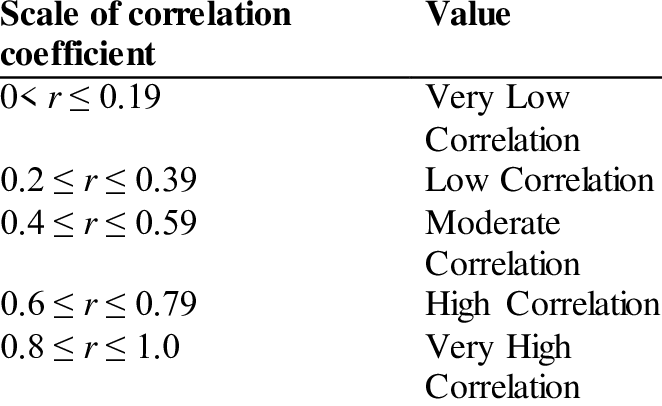


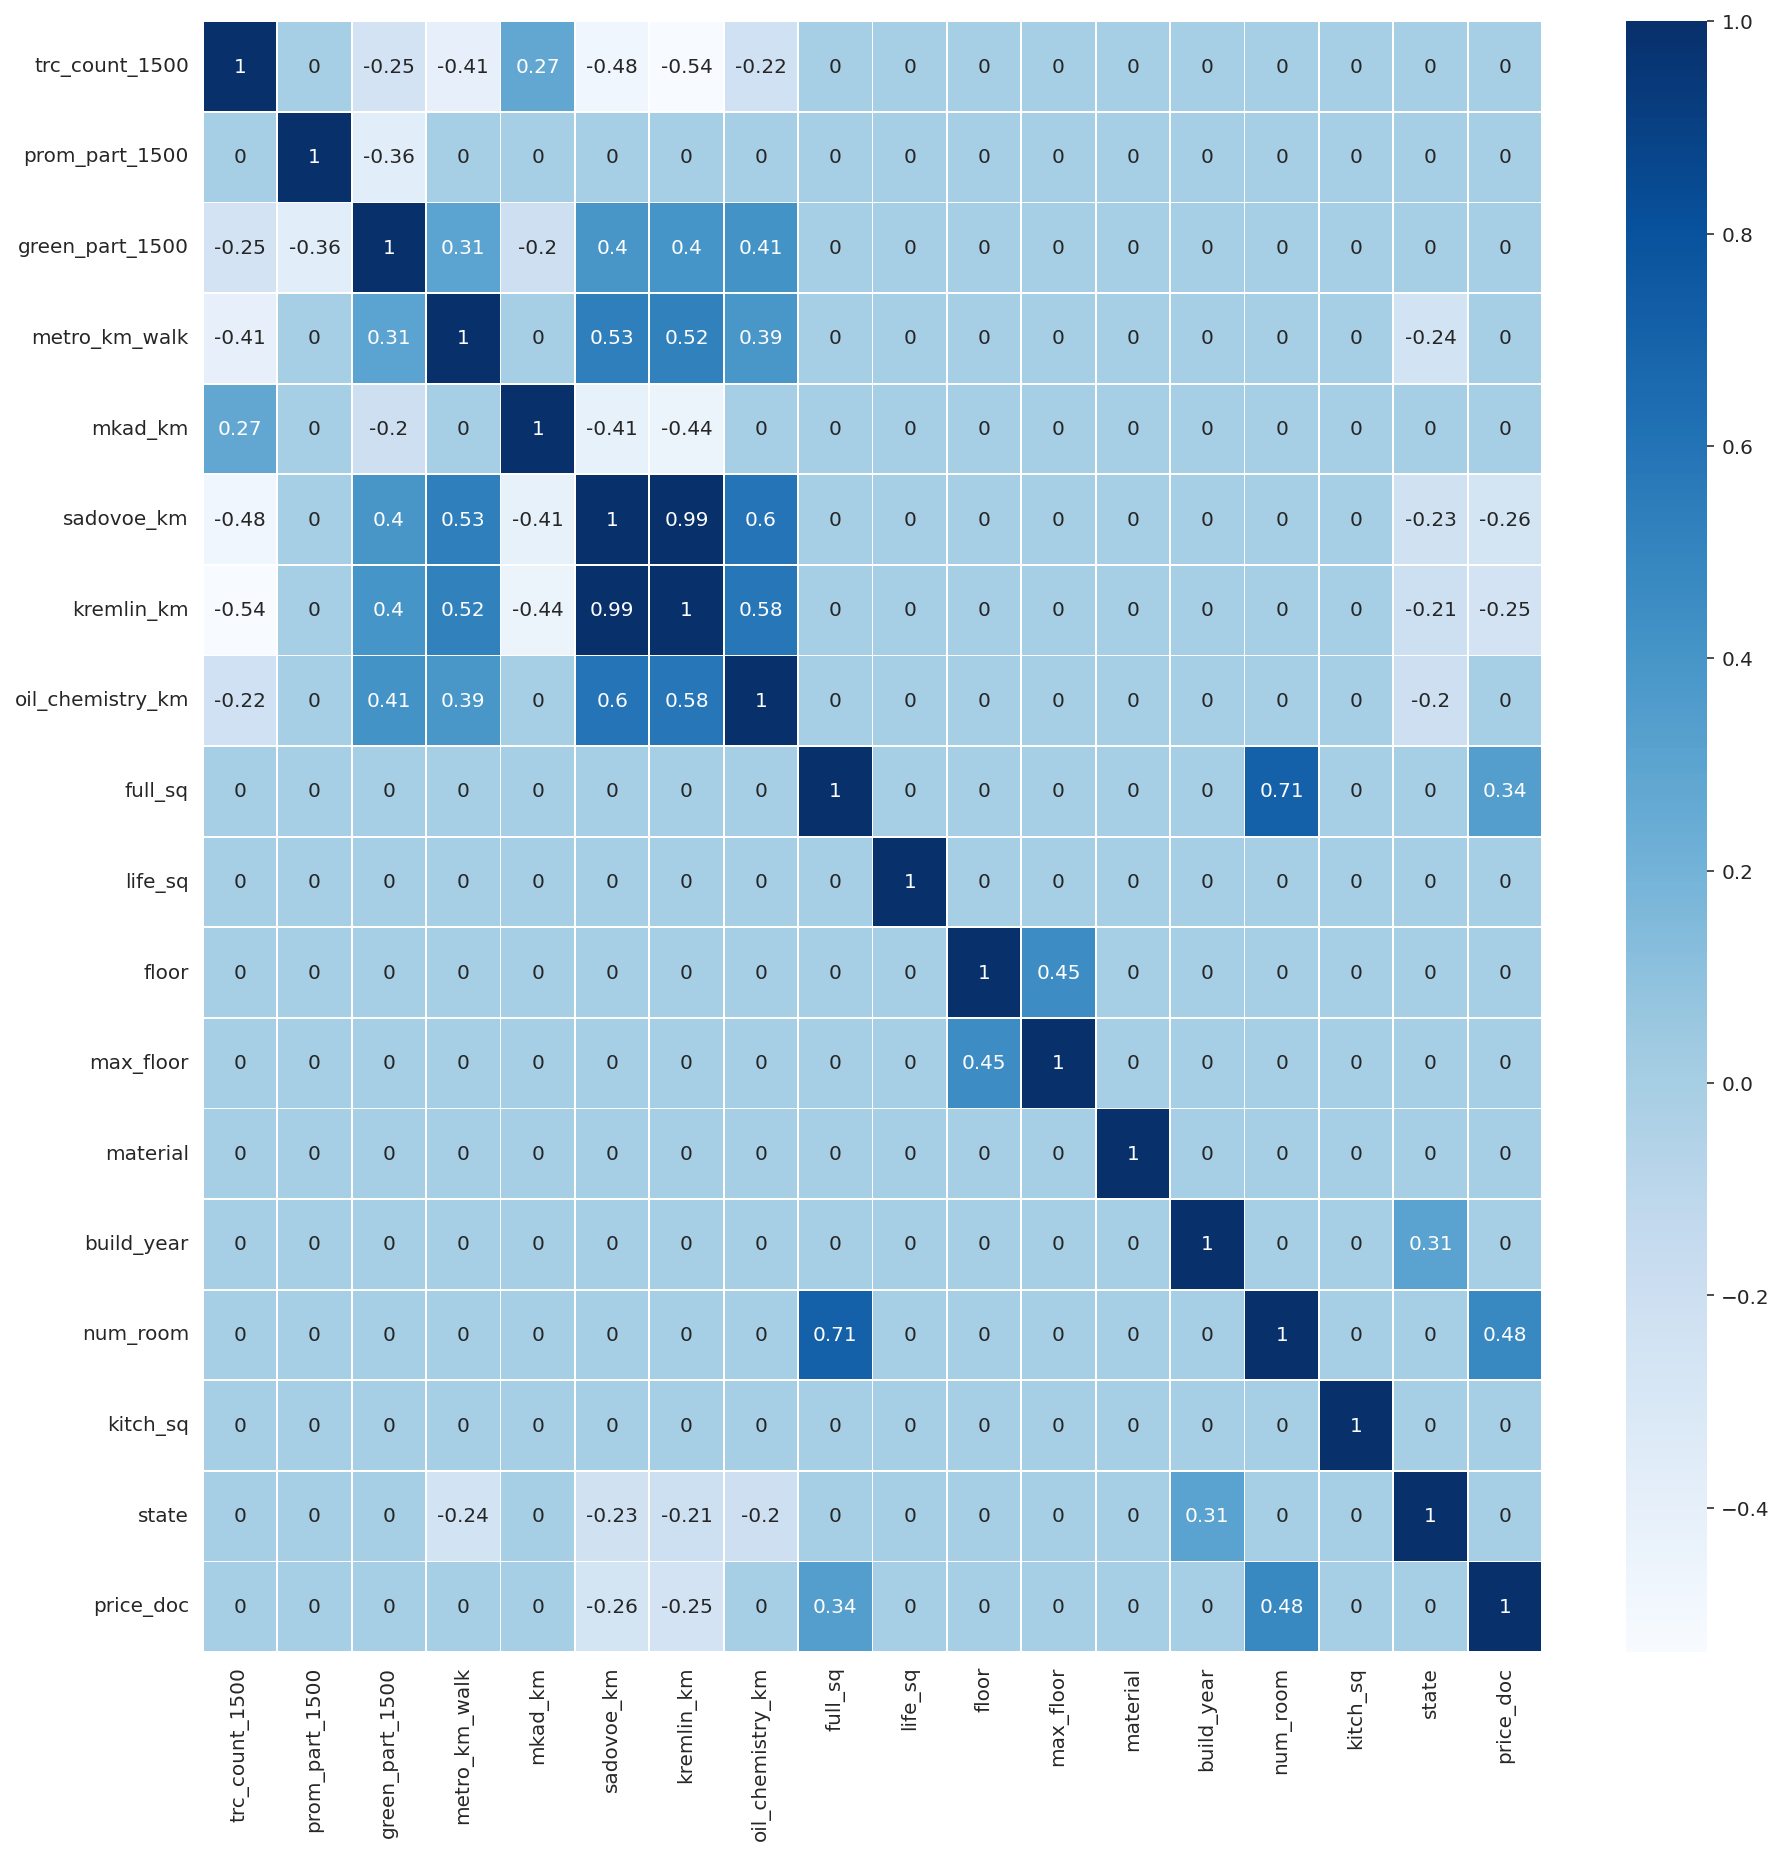

In [228]:
corr_matrix = data.corr()
corr_matrix[abs(corr_matrix) < 0.2] = 0

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax, cmap="Blues")

Исключая очевидные корреляции (напр: корр. расстояния от МКАДа до центра Москвы или от садового кольца до центра) и повторы, можем пронаблюдать следующие корреляции (начиная с +-0.2, `Low Moderate`):

  * Корреляция с <b>price_doc</b>:
    * `kremlin_km` (-0.25) (`Low Negative Correlation`)
    * `sadovoe_km` (-0.25) (`Low Negative Correlation`)
    * `num_room` (0.48) (`Moderate Positive Correlation`)
    * `life_sq` (0.45) (`Moderate Positive Correlation`)
    * `full_sq` (0.34) (`Low Positive Correlation`)
<br><br>
  * `tr_count_1500`:
    * `kremlin_km` (-0.52) `Moderate Negative Correlation`)
    * `sadovoe_km` (-0.46) (`Moderate Negative Correlation`)
    * `mkad_km` (0.3) (`Low Positive Correlation`)
    * `metro_km_walk` (-0.4) (`Moderate Negative Correlation`)
    * `green_part_1500` (-0.26) (`Low Negative Correlation`)
  * `green_part_1500`:
    * `oil_chemistry_km` (0.42) (`Moderate Positive Correlation`)
    * `kremlin_km` (0.43) (`Moderate Positive Correlation`)
    * `sadovoe_km` (0.43) (`Moderate Positive Correlation`)
    * `prom_part_1500` (-0.37) (`Low Negative Correlation`)
    * `metro_km_walk`(0.29) (`Low Positive Correlation`)
    * `mkad_km` (-0.22) (`Low Negative Correlation`)
  * `metro_km_walk`:
    * `state` (-0.23) (`Low Negative Correlation`)
    * `oil_chemistry_km` (0.37) (`Low Positive Correlation`)
    * `kremlin_km` (0.53) (`Moderate Positive Correlation`)
    * `sadovoe_km` (0.54) (`Moderate Positive Correlation`)
  * `mkad_km`:
    * `kremlin_km` (-0.52) (`Moderate Negative Correlation`)
    * `sadovoe_km` (-0.49) (`Moderate Negative Correlation`)
  * `sadovoe_km`:
    * `price_doc` (-0.25) (`Low Negative Correlation`)
    * `state` (-0.21) (`Low Negative Correlation`)
    * `max_floor` (0.22) (`Low Positive Correlation`)
    * `oil_chemistry_km` (0.58) (`Moderate Positive Correlation`)
    * `kremlin_km` (0.99) (**!!!Very High Positive Correlation!!!**)
  * `kremlin_km`:
    * `price_doc` (-0.25) (`Low Negative Correlation`)
    * `max_floor` (0.21) (`Low Positive Correlation`)
    * `oil_chemistry_km` (0.56) (`Moderate Positive Correlation`)
  * `full_sq`:
    * `price_doc` (0.34) (`Low Positive Correlation`)
    * `num_room` (0.71) (`High Positive Correlation`)
    * `life_sq` (0.38) (`Low Positive Correlation`)
  * `life_sq`:
    * `price_doc` (0.45) (`Moderate Positive Correlation`)
    * `num_room` (0.57) (`Moderate Positive Correlation`)
  * `max_floor`:
    * `floor` (0.46) (`Moderate Positive Correlation`)
  * `build_year`:
    * `state` (0.32) (`Low Positive Correlation`)
  * `num_room`:
    * `price_doc` (0.48) (`Moderate Positive Correlation`)

График медианы цены к расстоянию от центра Москвы:

In [229]:
# Будем брать интервалы по 2 км

lines = data.groupby(pd.cut(data['kremlin_km'], np.arange(0, 25, 2)))['price_doc'].median()

In [230]:
# Заменим индексы на левую границу

lines.index =  np.arange(0, 24, 2)

In [231]:
# Стат. признаки

max_lines, min_lines, mean_lines, median_lines = max(lines), min(lines), np.mean(lines), np.median(lines)

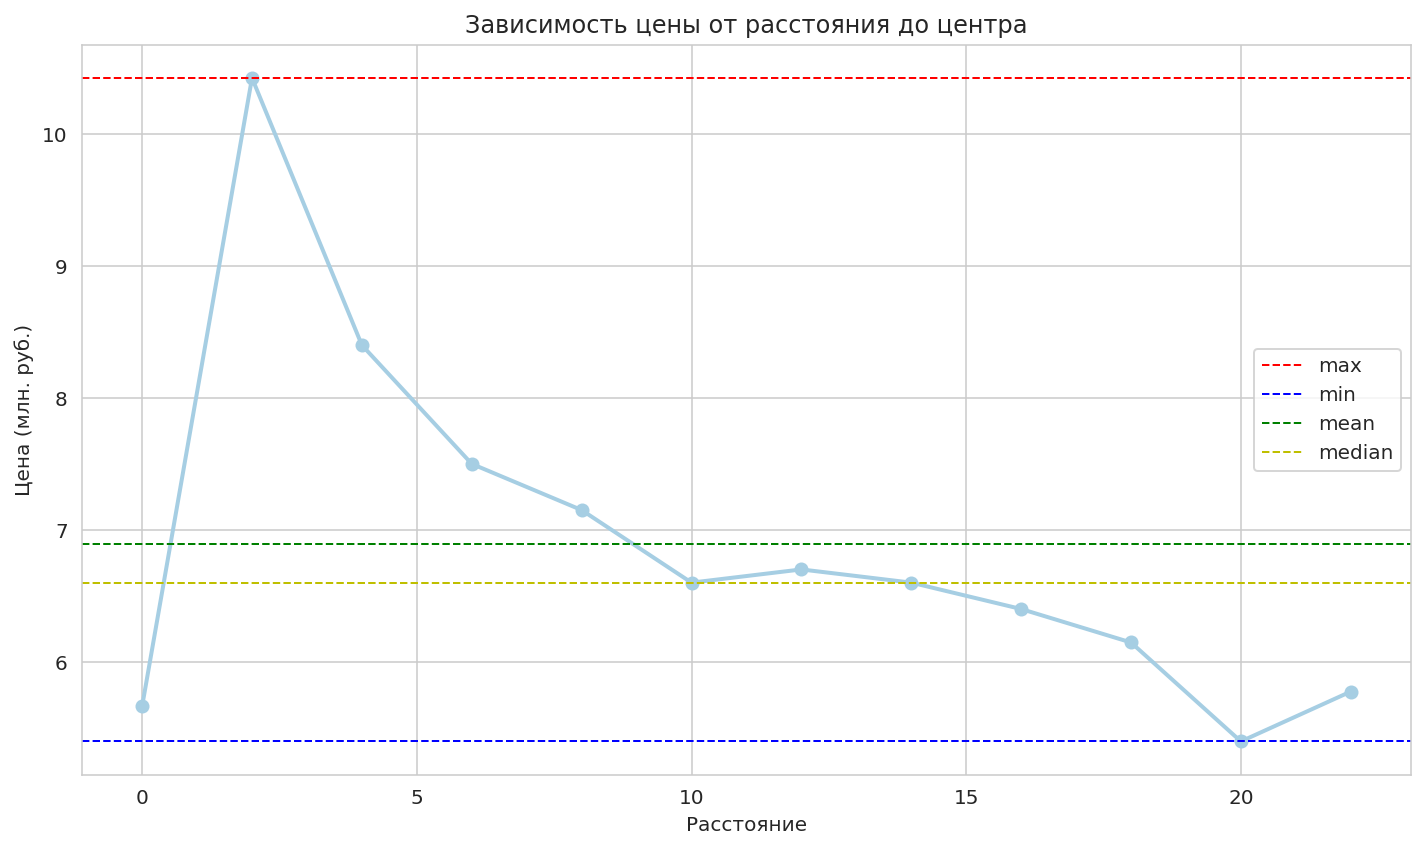

In [232]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

ax.plot(lines, 'o-', linewidth=2)
ax.ticklabel_format(style='plain')
plt.xlabel('Расстояние')
plt.ylabel('Цена (млн. руб.)')
plt.title('Зависимость цены от расстояния до центра')

plt.axhline(max_lines, color='r', linestyle='dashed', linewidth=1, label='max')
plt.axhline(min_lines, color='b', linestyle='dashed', linewidth=1, label='min')
plt.axhline(mean_lines, color='g', linestyle='dashed', linewidth=1, label='mean')
plt.axhline(median_lines, color='y', linestyle='dashed', linewidth=1, label='median')
ax.legend()
plt.show()

Всё, что в радиусе километра от центра, возможно уже не продается по следующим причинам:
* Гос. имущество
* Продолжительное время в частной собственности
* Данные о таких крупных сделках просто отсутствуют

In [233]:
lines = pd.DataFrame(lines)
lines.index = lines.index.set_names(['kremlin_km'])
lines = lines.reset_index()

In [234]:
lines.head()

,kremlin_km,price_doc
0,0,5.6631
1,2,10.4250
2,4,8.4000
3,6,7.5000
4,8,7.1500


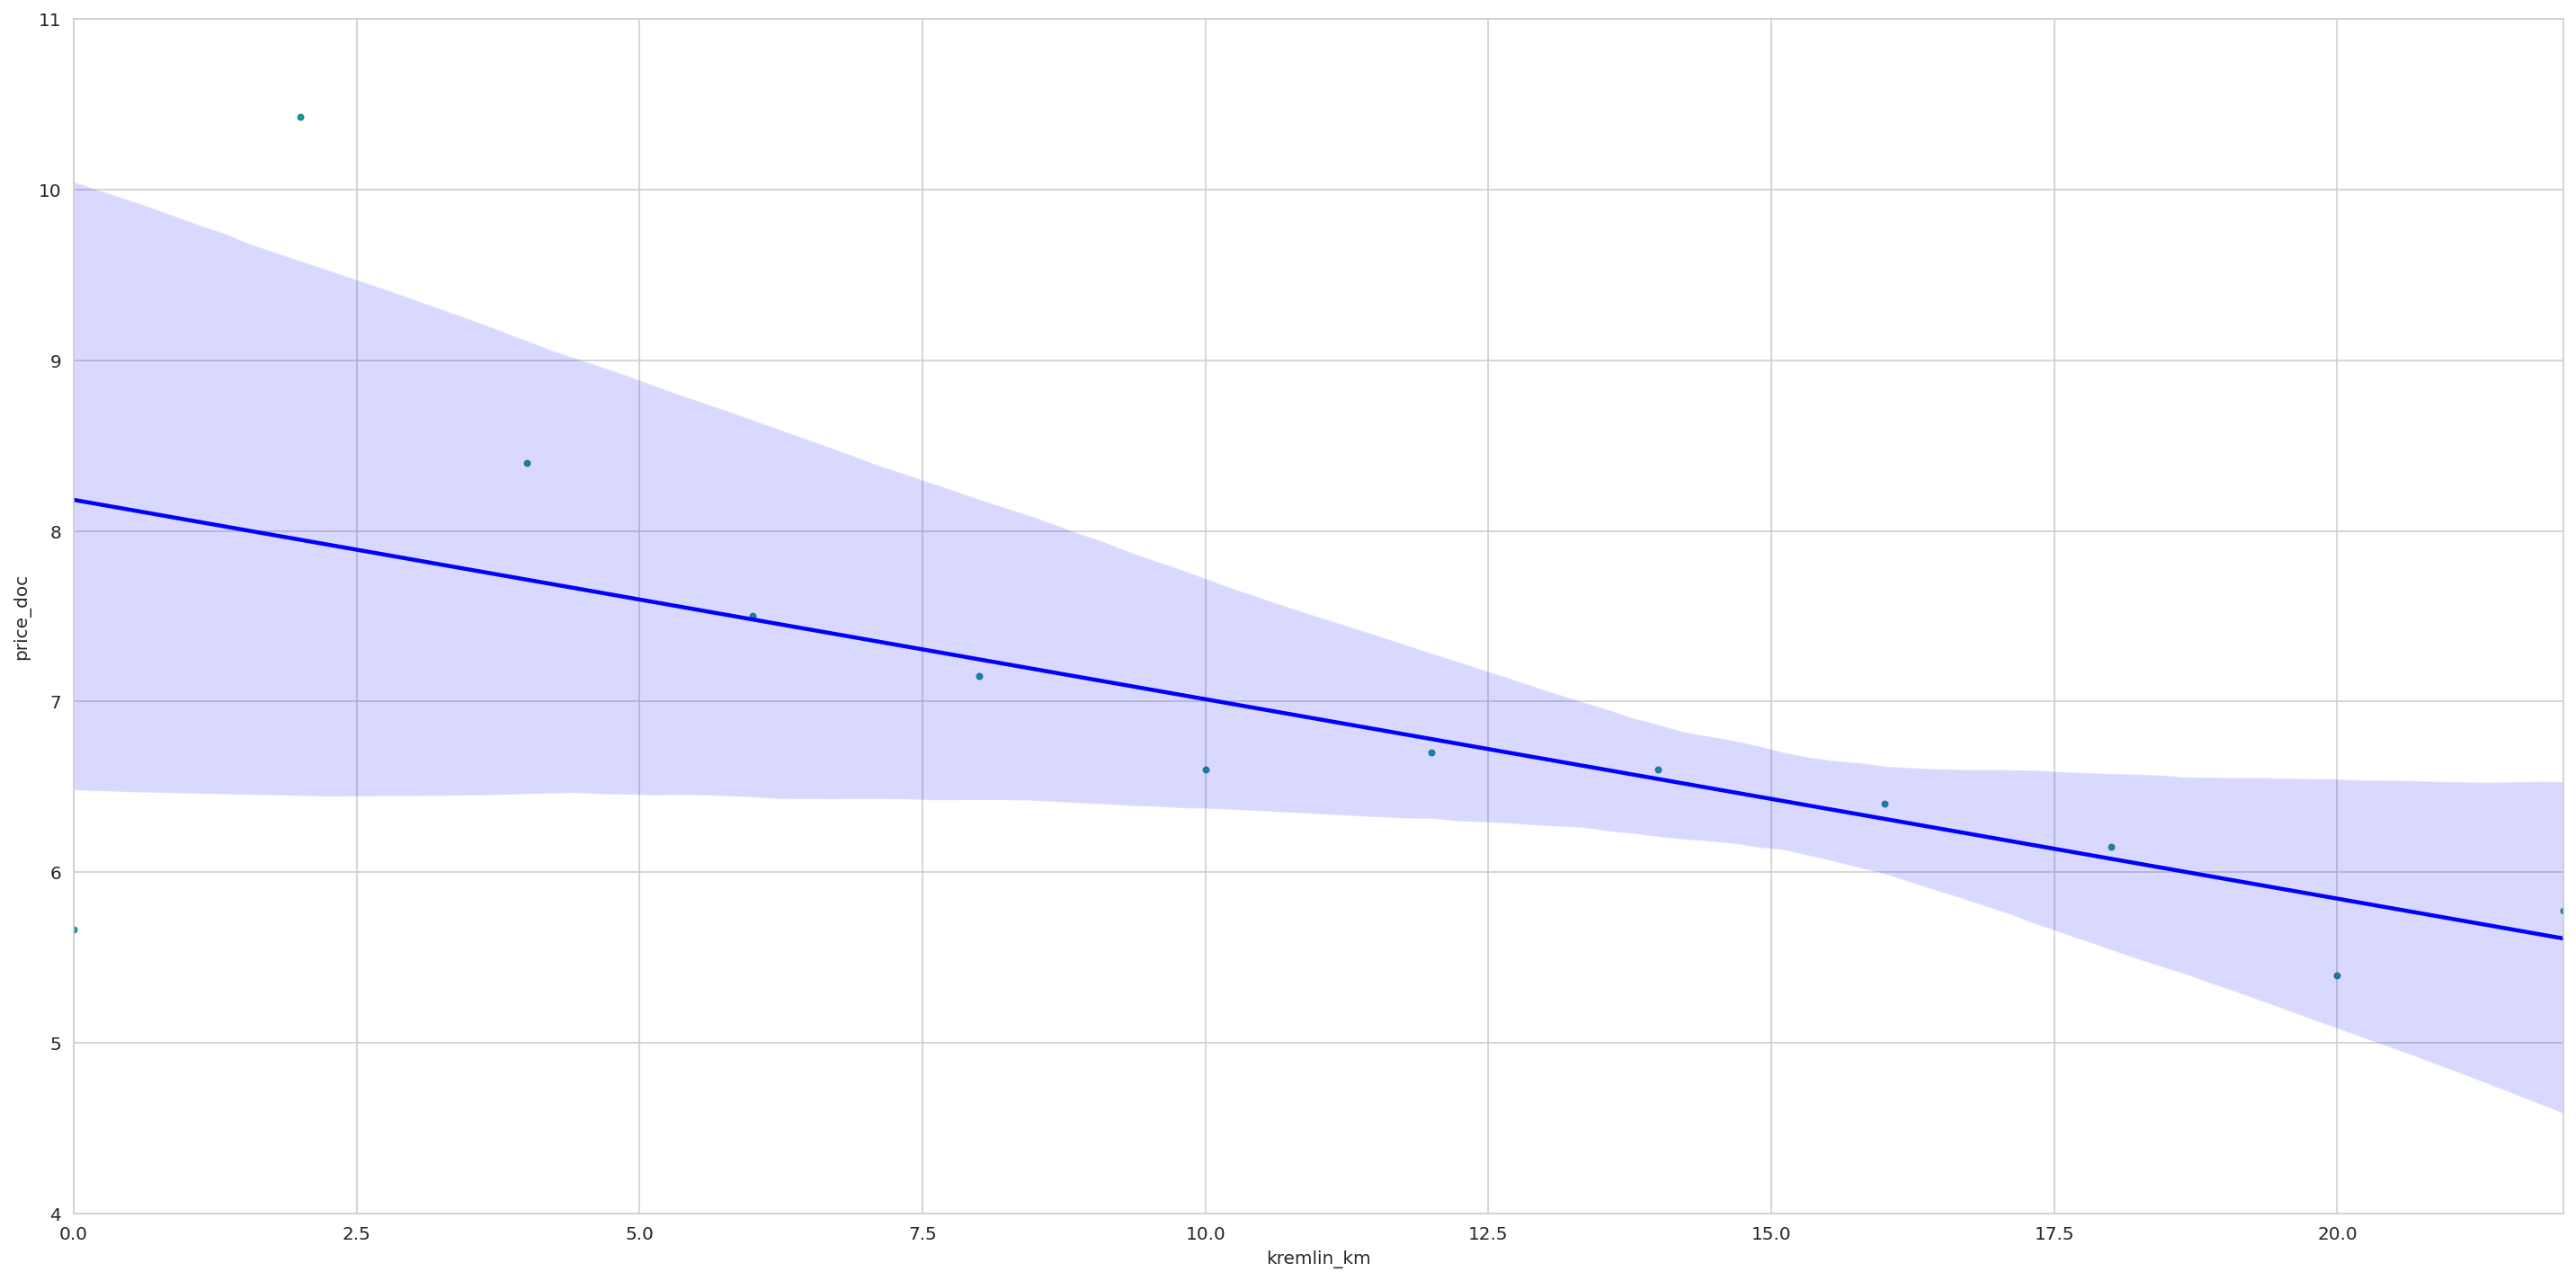

In [235]:
fig, ax = plt.subplots(figsize=(20, 10), tight_layout=True)

plt.ylim(4, 11)
plt.xlim(0, 22)
sns.regplot(x="kremlin_km", y="price_doc", data=lines,
                 scatter_kws={"color": "teal"}, line_kws={"color": "blue"}, marker=".");

Поиск очевидного излома не дал конкретных результатов

Промежуточный вывод:
  * Название столбцов в `snake_case`
  * В столбцах есть пропуски. В некоторых столбцах превышают 10%, удаление нежелательно
  * Дубликаты обнаружены и удалены
  * Большинство столбцов уже имеют правильный тип данных
  * Прослеживается явная зависимость цены от расстояния до центра
  * Корреляция с <b>price_doc</b>:
    * `kremlin_km` (-0.25) (`Low Negative Correlation`)
    * `sadovoe_km` (-0.25) (`Low Negative Correlation`)
    * `num_room` (0.48) (`Moderate Positive Correlation !!!`)
    * `life_sq` (0.45) (`Moderate Positive Correlation !!!`)
    * `full_sq` (0.34) (`Low Positive Correlation`)
  * `timestamp` будет приведён к типу `datetime`
  * `float` (кроме `price_doc`) будет округлён до второго знака после запятой
  * `price_doc` теперь с у.е. 1 млн. руб


<h3>Изучим признаки:</h3>

Начнём с анализов признаков, которые описывают район в окрестностях 1,5 км:<br><br>
* `trc_count_1500` - Количество торговых центров в зоне 1500 метров
* `prom_part_1500` - Доля промышленных зон в зоне 1500 метров
* `green_part_1500` - Доля зеленых зон в зоне 1500 метров

In [236]:
zone_1500 = ['trc_count_1500', 'prom_part_1500', 'green_part_1500']

data[zone_1500].head()

,trc_count_1500,prom_part_1500,green_part_1500
0,9,6.9200,14.2700
1,7,7.7100,21.5300
2,1,6.7300,9.9200
3,7,6.5700,28.3800
4,9,4.8300,4.1200


In [237]:
data[zone_1500].describe()

,trc_count_1500,prom_part_1500,green_part_1500
count,27494.0000,27494.0000,27494.0000
mean,4.0496,11.0000,18.6647
std,4.5858,11.3039,13.1019
min,0.0000,0.0000,0.0000
25%,1.0000,1.4500,8.8900
50%,3.0000,7.9500,14.8300
75%,6.0000,16.4900,26.4600
max,27.0000,63.0000,90.4100


In [238]:
data[zone_1500].isna().sum()

trc_count_1500     0
prom_part_1500     0
green_part_1500    0
dtype: int64

Пропусков нет

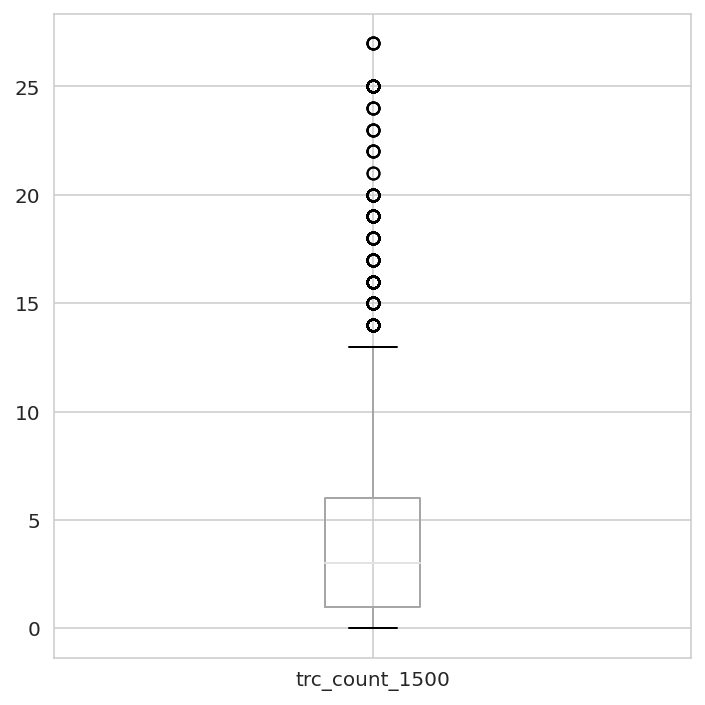

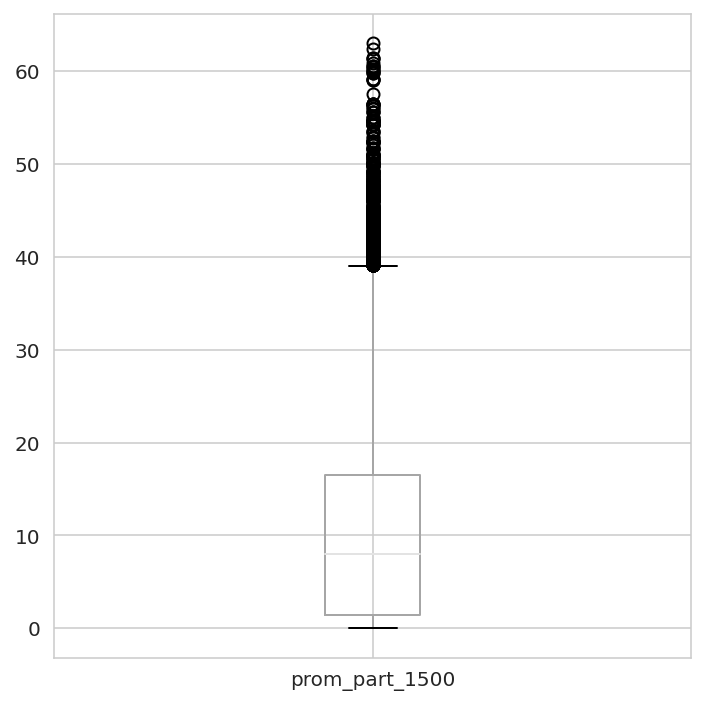

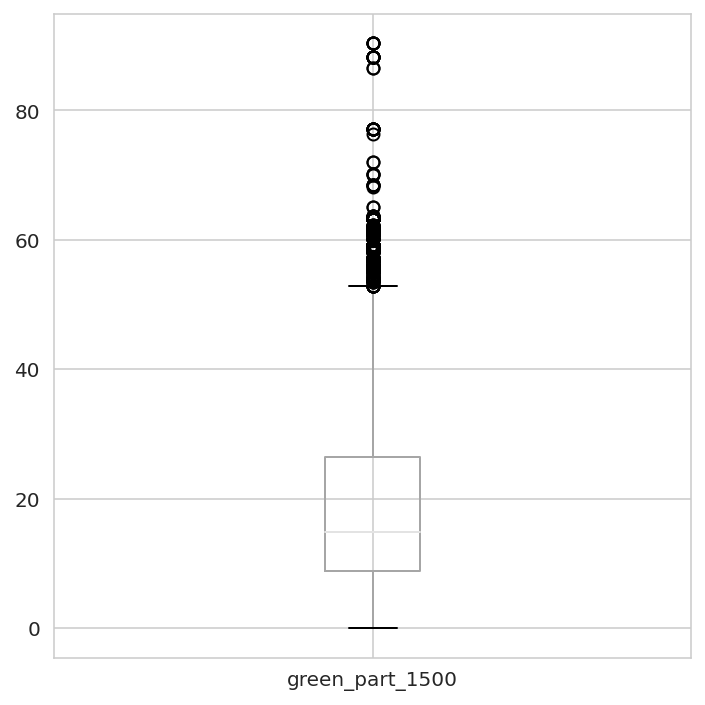

In [239]:
for col in zone_1500:
    plt.figure(figsize=(5, 5), tight_layout=True)
    data.boxplot(col)
    

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


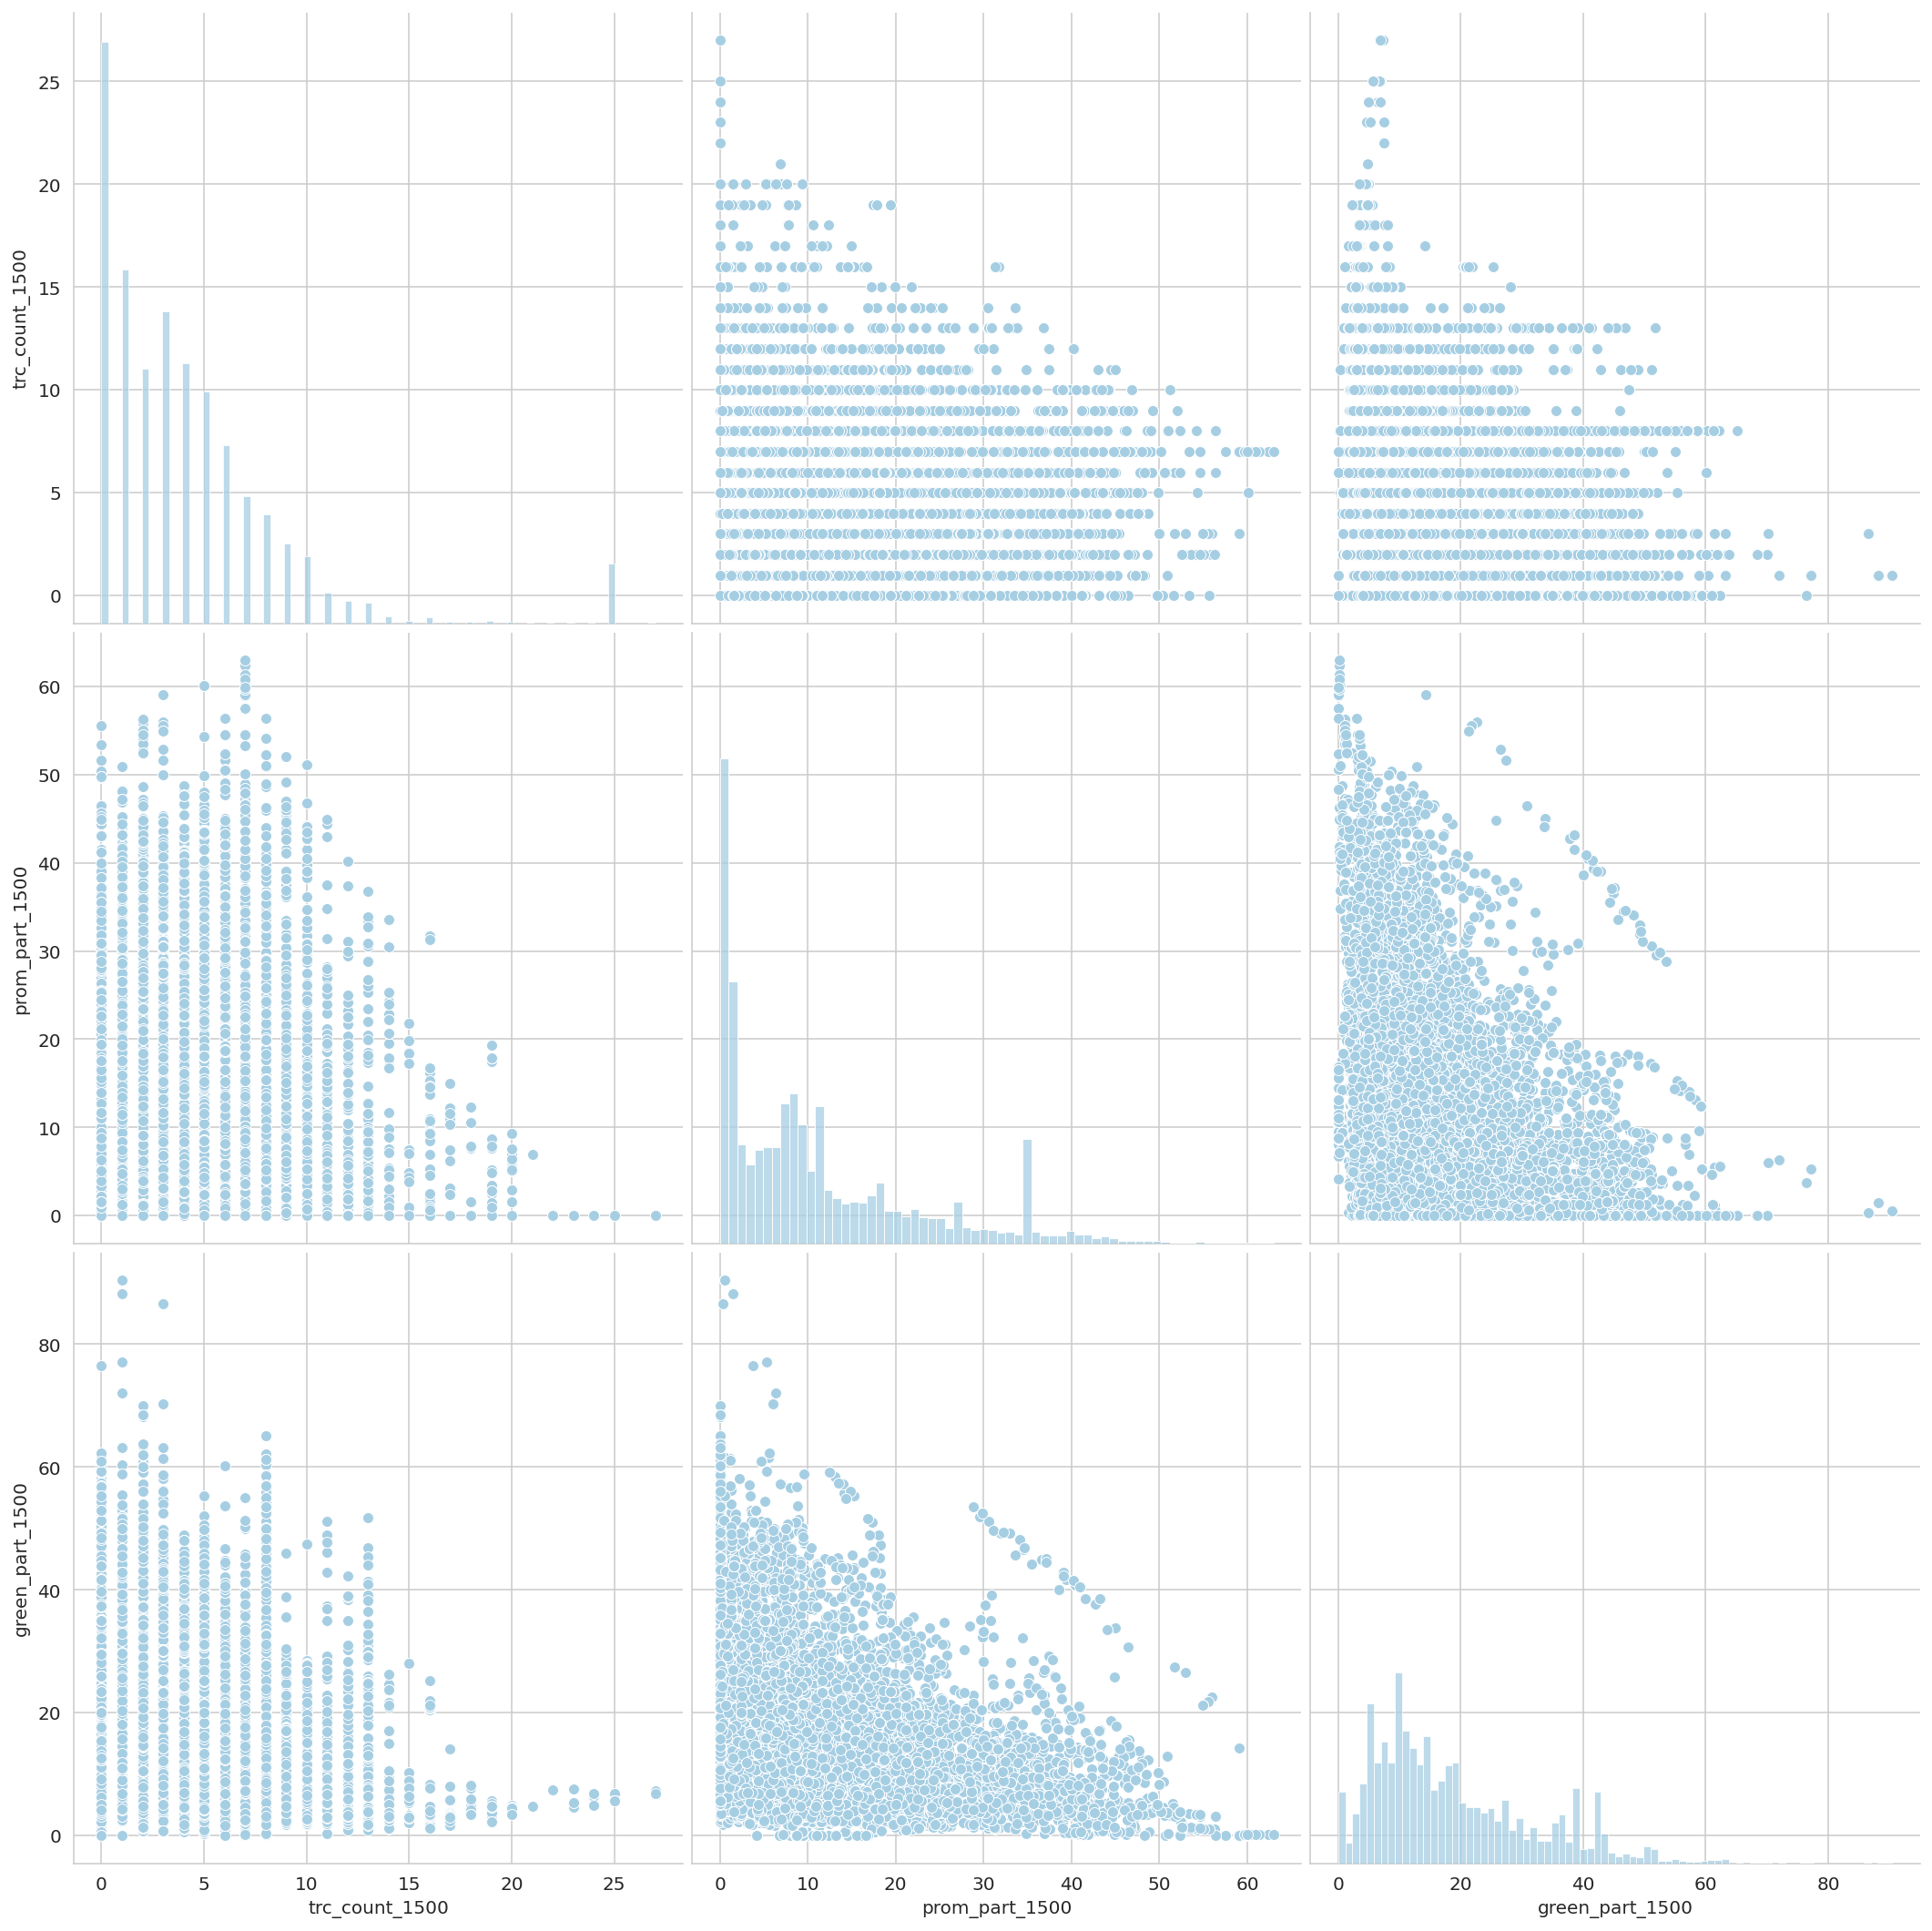

In [240]:
sns.pairplot(data[zone_1500], size=5);


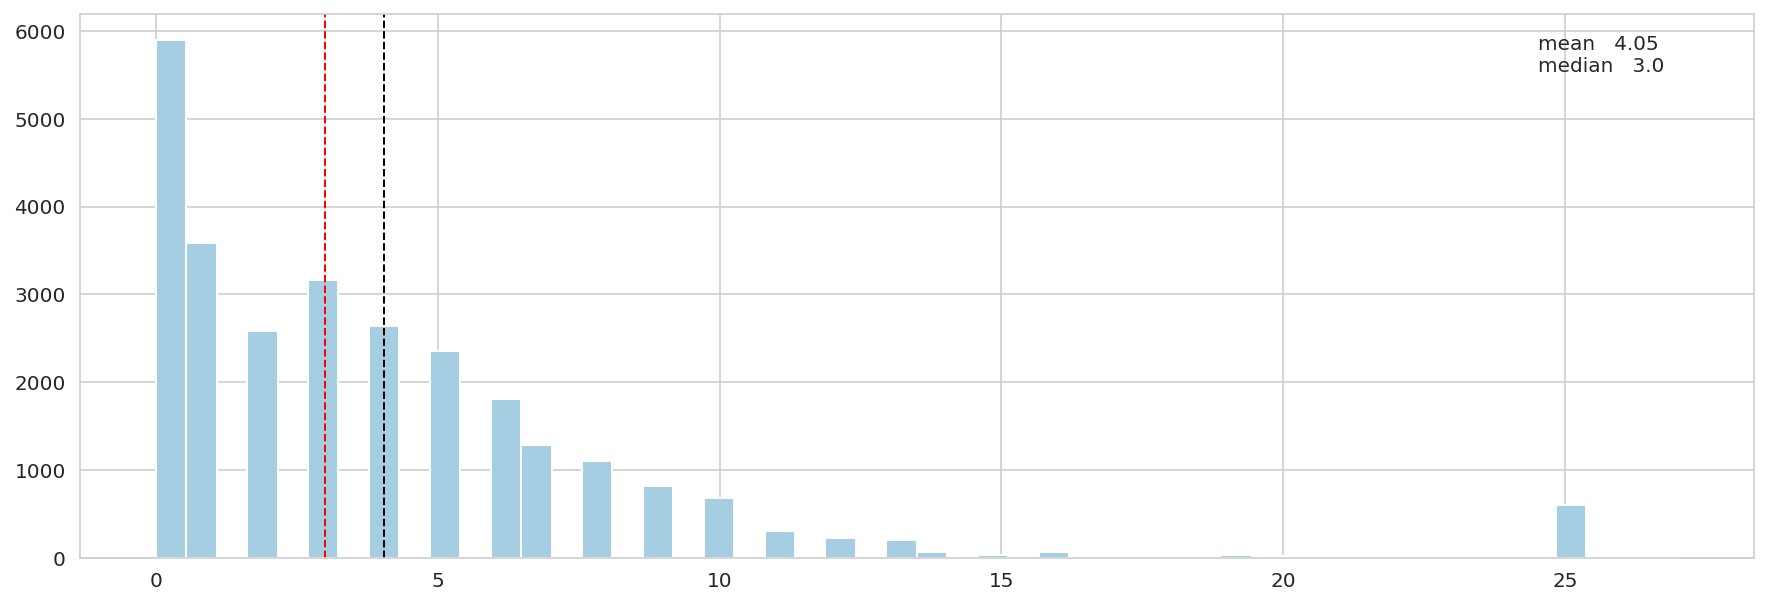

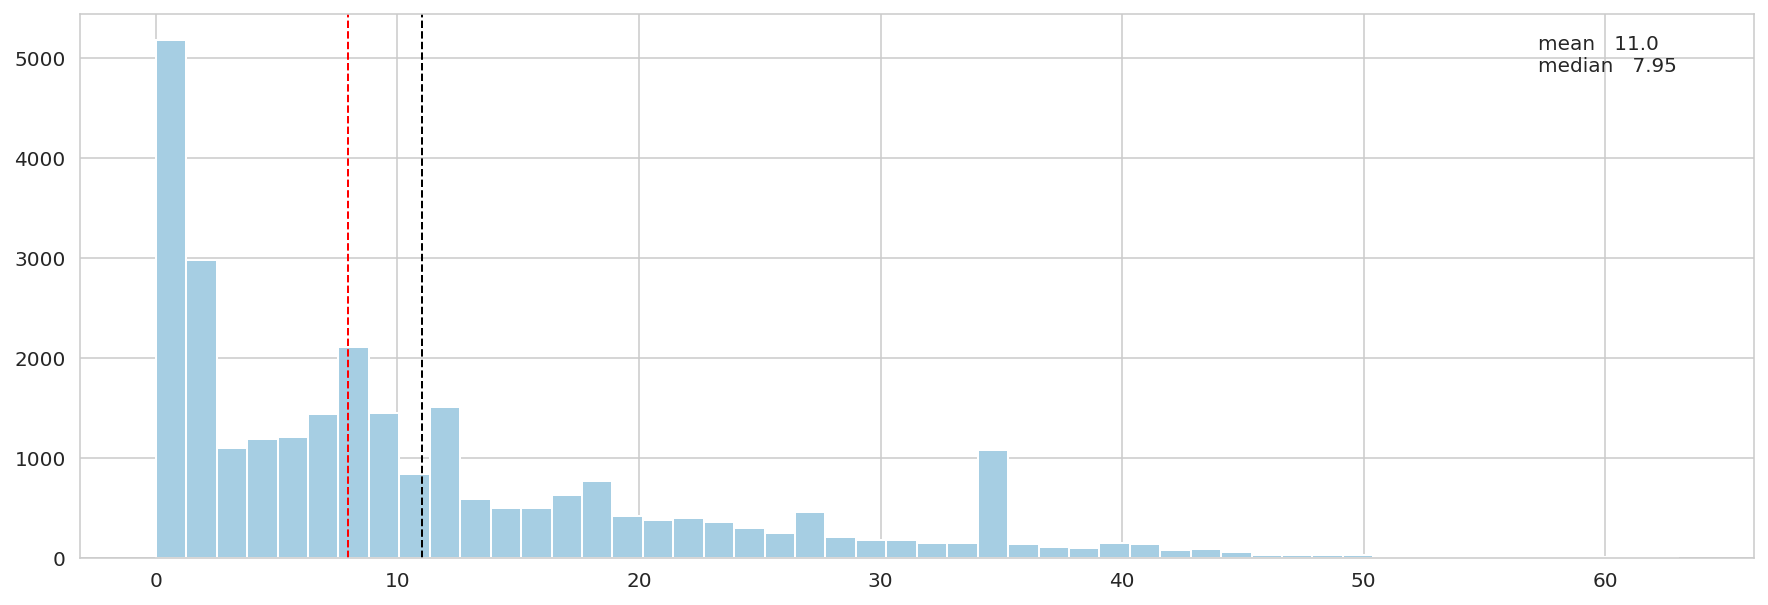

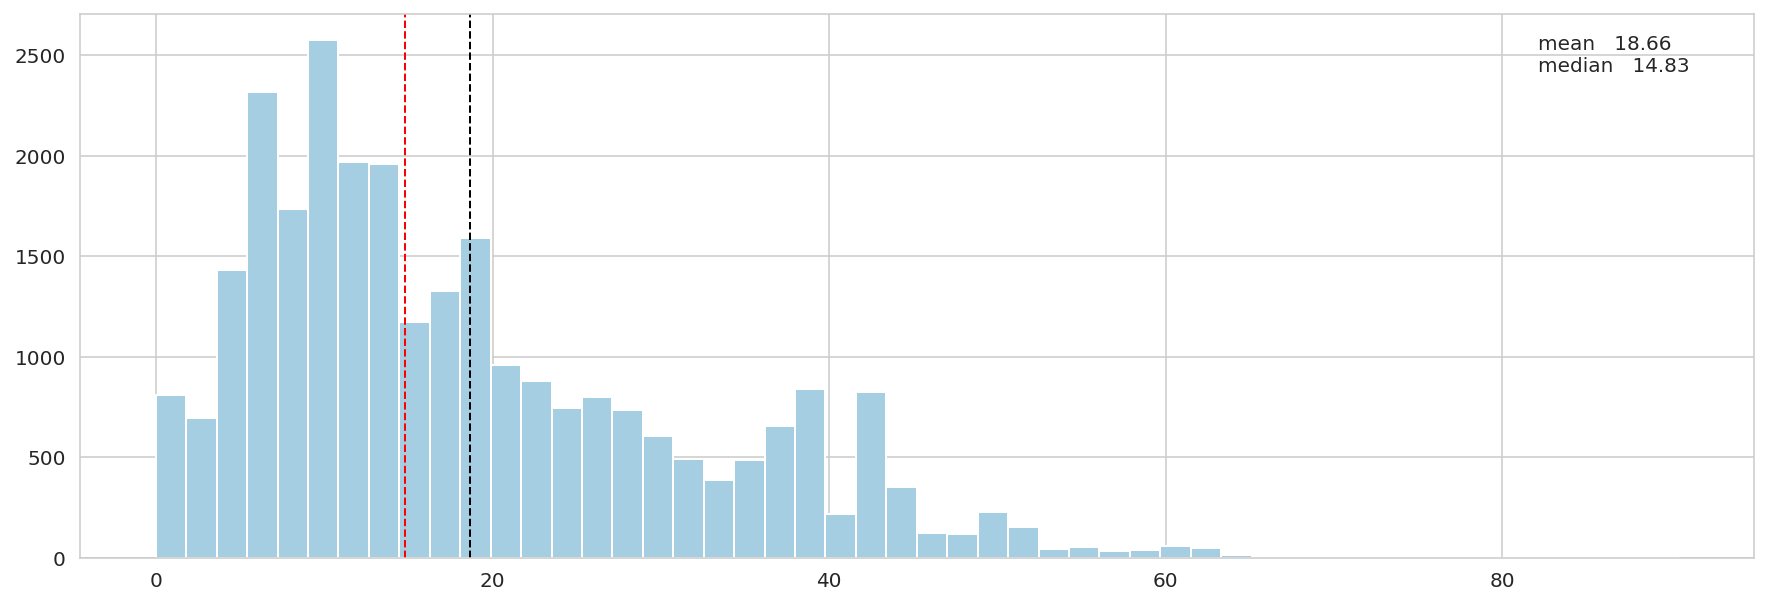

In [241]:
for col in zone_1500:
    trc_mean = data[col].mean()
    trc_median = data[col].median()
    mean_now = f'mean   {round(trc_mean, 2)}\n'
    median_now = f'median   {round(trc_median, 2)}'
    desc = mean_now + median_now
    plt.figure()
    plt.figtext(.8, .8, desc)
    plt.axvline(trc_mean, color='k', linestyle='dashed', linewidth=1, label='mean')
    plt.axvline(trc_median, color='r', linestyle='dashed', linewidth=1, label='median')
    data[col].hist(bins=50, figsize=(15,5));

Можем наблюдать выбросы.

In [242]:
q1 = round(np.percentile(np.array(data['trc_count_1500']), 25))
q3 = round(np.percentile(np.array(data['trc_count_1500']), 75))
print(f'Обычно количество промышленных центров в зоне 1500 метров находится в интервале от {q1} до {q3} центров')
print(f'Количество аномальных записей по признаку: {len(data.query("trc_count_1500 < 1 or trc_count_1500 > 6"))}')

Обычно количество промышленных центров в зоне 1500 метров находится в интервале от 1 до 6 центров
Количество аномальных записей по признаку: 11377


In [243]:
q1 = round(np.percentile(np.array(data['prom_part_1500']), 25))
q3 = round(np.percentile(np.array(data['prom_part_1500']), 75))
print(f'Обычно доля промышленных зон в зоне 1500 метров находится в интервале от {q1}% до {q3}%')
print(f'Количество аномальных записей по признаку: {len(data.query("prom_part_1500 < 2 or prom_part_1500 > 17"))}')

Обычно доля промышленных зон в зоне 1500 метров находится в интервале от 1% до 16%
Количество аномальных записей по признаку: 14197


In [244]:
q1 = round(np.percentile(np.array(data['green_part_1500']), 25))
q3 = round(np.percentile(np.array(data['green_part_1500']), 75))
print(f'Чаще всего доля зеленых зон в зоне 1500 метров находится в интервале от {q1}% до {q3}%')
print(f'Количество аномальных записей по признаку: {len(data.query("green_part_1500 < 9 or green_part_1500 > 27"))}')

Чаще всего доля зеленых зон в зоне 1500 метров находится в интервале от 9% до 26%
Количество аномальных записей по признаку: 13507


Признаки с расстоянием в километрах:
  * `metro_km_walk` - км до ближ. метро
  * `mkad_km` - км до МКАДа
  * `sadovoe_km` - км до Сад. кольца
  * `kremlin_km` - км до центра Москвы (Кремль)
  * `oil_chemistry_km` - км до "грязного" производства


In [245]:
km_features = ['metro_km_walk', 'mkad_km', 'sadovoe_km', 'kremlin_km', 'oil_chemistry_km']

In [246]:
data[km_features].head()

,metro_km_walk,mkad_km,sadovoe_km,kremlin_km,oil_chemistry_km
0,1.1313,1.4224,13.1006,15.1562,18.1523
1,0.6351,9.5034,6.4443,8.6981,9.0346
2,1.4460,5.6048,6.9634,9.0679,5.7774
3,0.9638,2.6778,17.4572,19.4870,27.6679
4,0.6889,11.6167,0.0468,2.5787,6.5159


In [247]:
data[km_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27494 entries, 0 to 30470
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   metro_km_walk     27469 non-null  float64
 1   mkad_km           27494 non-null  float64
 2   sadovoe_km        27494 non-null  float64
 3   kremlin_km        27494 non-null  float64
 4   oil_chemistry_km  27494 non-null  float64
dtypes: float64(5)
memory usage: 2.3 MB


In [248]:
data[km_features].describe()

,metro_km_walk,mkad_km,sadovoe_km,kremlin_km,oil_chemistry_km
count,27469.0000,27494.0000,27494.0000,27494.0000,27494.0000
mean,2.0568,5.2047,12.1595,14.1490,15.3278
std,1.6891,3.3427,5.8704,6.0259,8.0600
min,0.0000,0.0136,0.0004,0.0729,0.5107
25%,0.8865,2.4983,7.8026,9.8950,8.4834
50%,1.5164,4.6705,11.6914,13.8062,14.8323
75%,2.4369,7.4660,17.4806,19.5253,21.9045
max,9.7151,14.5611,24.0026,25.9843,33.6604


Применим **Метод дополнительных регрессий (Тест VIF)** для проверки мультиколлинеарности (в особенности `mkad_km` и `sadovoe_km`):

In [249]:
vif_data = pd.DataFrame()
vif_data["feature"] = km_features
  

vif_data["VIF"] = ([variance_inflation_factor(data[km_features].dropna().values, i)
                          for i in range(len(km_features))])
  
print(vif_data)

            feature      VIF
0     metro_km_walk   3.5710
1           mkad_km   2.5223
2        sadovoe_km 300.9061
3        kremlin_km 304.6875
4  oil_chemistry_km   7.4521


Результаты VIF>10 могут говорить о высокой степени мультиколлинеарности. 

Действительно, `sadovoe_km` и `kremlin_km` мультиколлинеарны по смыслу

Округлим признаки до первого знака после запятой:

In [250]:
data[km_features] = data[km_features].round(1)

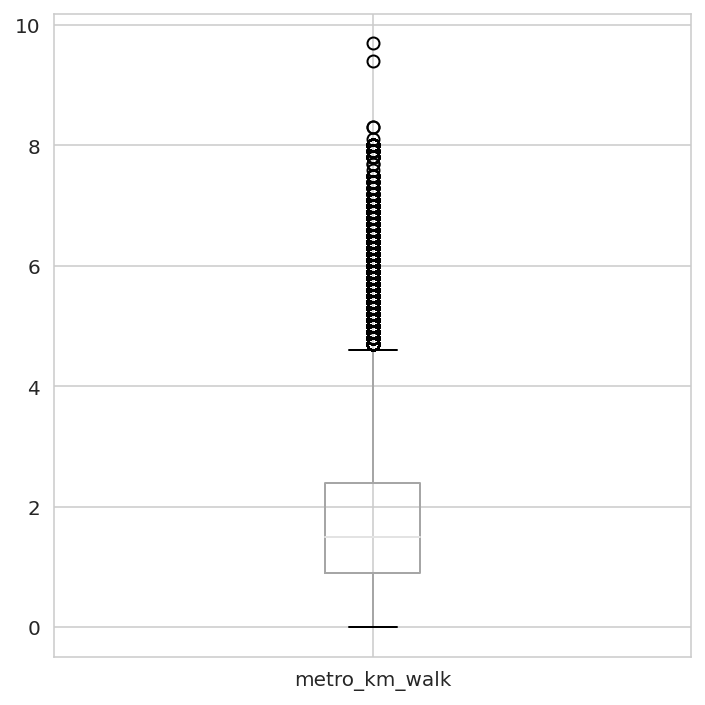

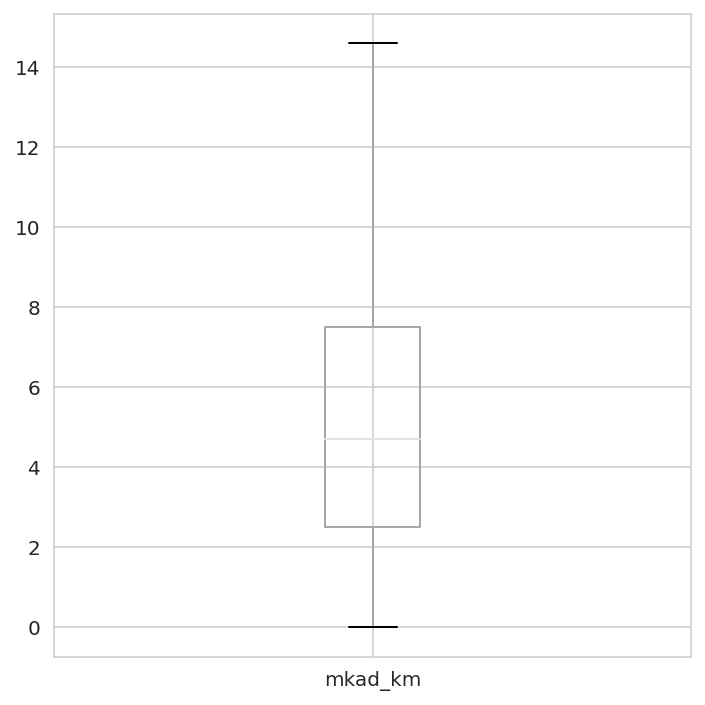

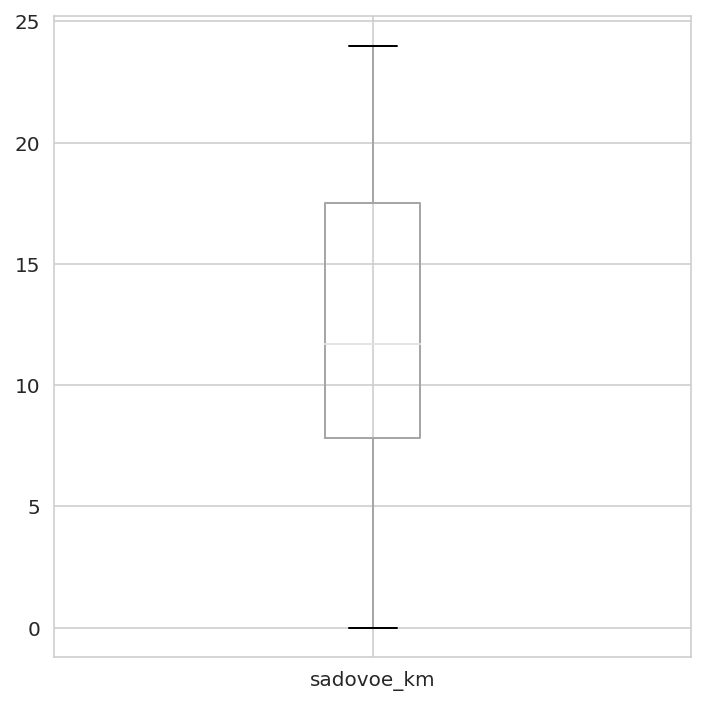

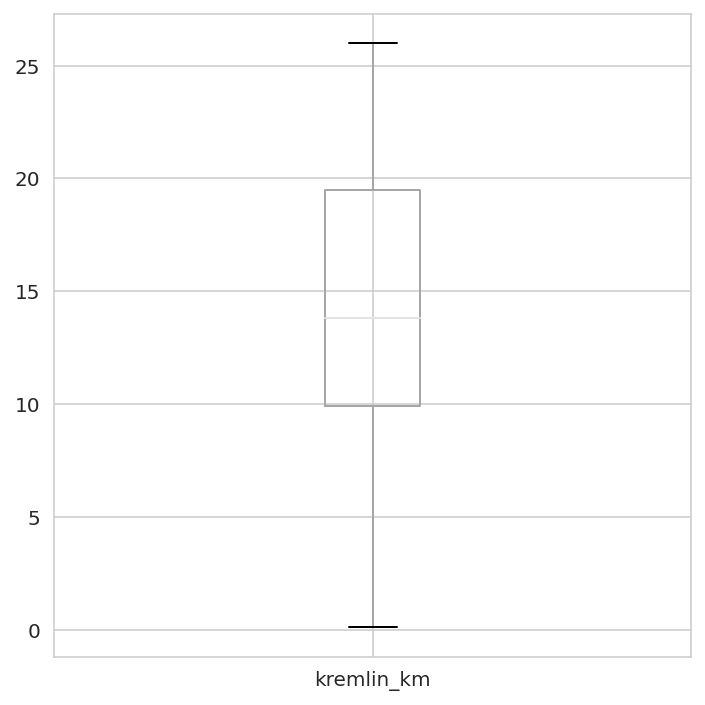

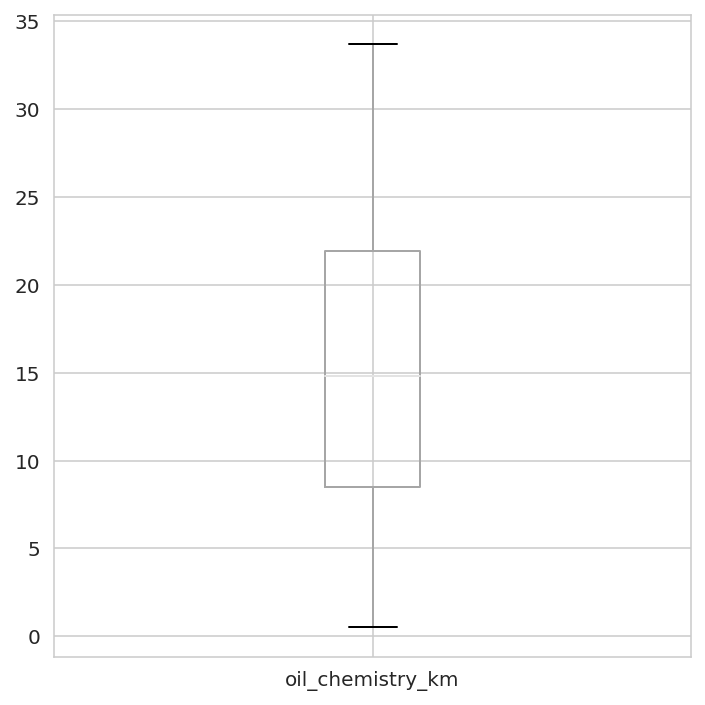

In [251]:
for col in km_features:
    plt.figure(figsize=(5, 5), tight_layout=True)
    data.boxplot(col)

Наблюдаем выбросы в `metro_km_walk`

Используем **Фильтр Хэмпеля** для замены на `NaN` в `metro_km_walk` всех значений, у которых разница с медианой больше, чем три медианных абсолютных отклонения. 

In [252]:
def hampel(data: pd.Series) -> pd.Series:
    data_copy = data.copy()    
    difference = np.abs(data_copy.median() - data_copy)
    med_abs_dev = difference.median()
    thresh = med_abs_dev * 3
    outlier_idx = difference > thresh
    data_copy[outlier_idx] = np.nan
    return data_copy

print("До:", (data['metro_km_walk']).isna().mean() * 100)
print("После:", hampel(data['metro_km_walk']).isna().mean() * 100)

До: 0.09092892994835236
После: 17.949370771804755


In [253]:
 hampel(data['metro_km_walk']).describe()

count   22559.0000
mean        1.3697
std         0.7647
min         0.0000
25%         0.8000
50%         1.3000
75%         1.9000
max         3.6000
Name: metro_km_walk, dtype: float64

Временные признаки:
  * `timestamp` - время транзакции 
  * `year_build` - год постройки

In [254]:
data['timestamp'][:5]

0    2011-08-20
1    2011-08-23
2    2011-08-27
3    2011-09-01
4    2011-09-05
Name: timestamp, dtype: object

In [255]:
data['timestamp'].describe()

count          27494
unique          1161
top       2014-12-16
freq             135
Name: timestamp, dtype: object

Приведём к типу `datetime64[ns]`:

In [256]:
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d')

In [257]:
data['timestamp'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   27494
unique                   1161
top       2014-12-16 00:00:00
freq                      135
first     2011-08-20 00:00:00
last      2015-06-30 00:00:00
Name: timestamp, dtype: object

In [258]:
data['timestamp'].value_counts()

2014-12-16    135
2014-12-09    123
2014-06-30    121
2014-12-18    107
2014-11-25     80
             ... 
2014-11-04      1
2014-11-03      1
2013-07-14      1
2011-08-23      1
2011-08-20      1
Name: timestamp, Length: 1161, dtype: int64

Сделаем ресемплирование по месяцам (среднее цены):

In [259]:
res = pd.DataFrame(data['price_doc'])
res.index = data['timestamp']
res.head()

,price_doc
timestamp,
2011-08-20,5.8500
2011-08-23,6.0000
2011-08-27,5.7000
2011-09-01,13.1000
2011-09-05,16.3315


In [260]:
res = pd.DataFrame(res.resample('1M').mean())
res.head()

,price_doc
timestamp,
2011-08-31,5.8500
2011-09-30,6.0050
2011-10-31,5.8688
2011-11-30,6.1817
2011-12-31,5.9685


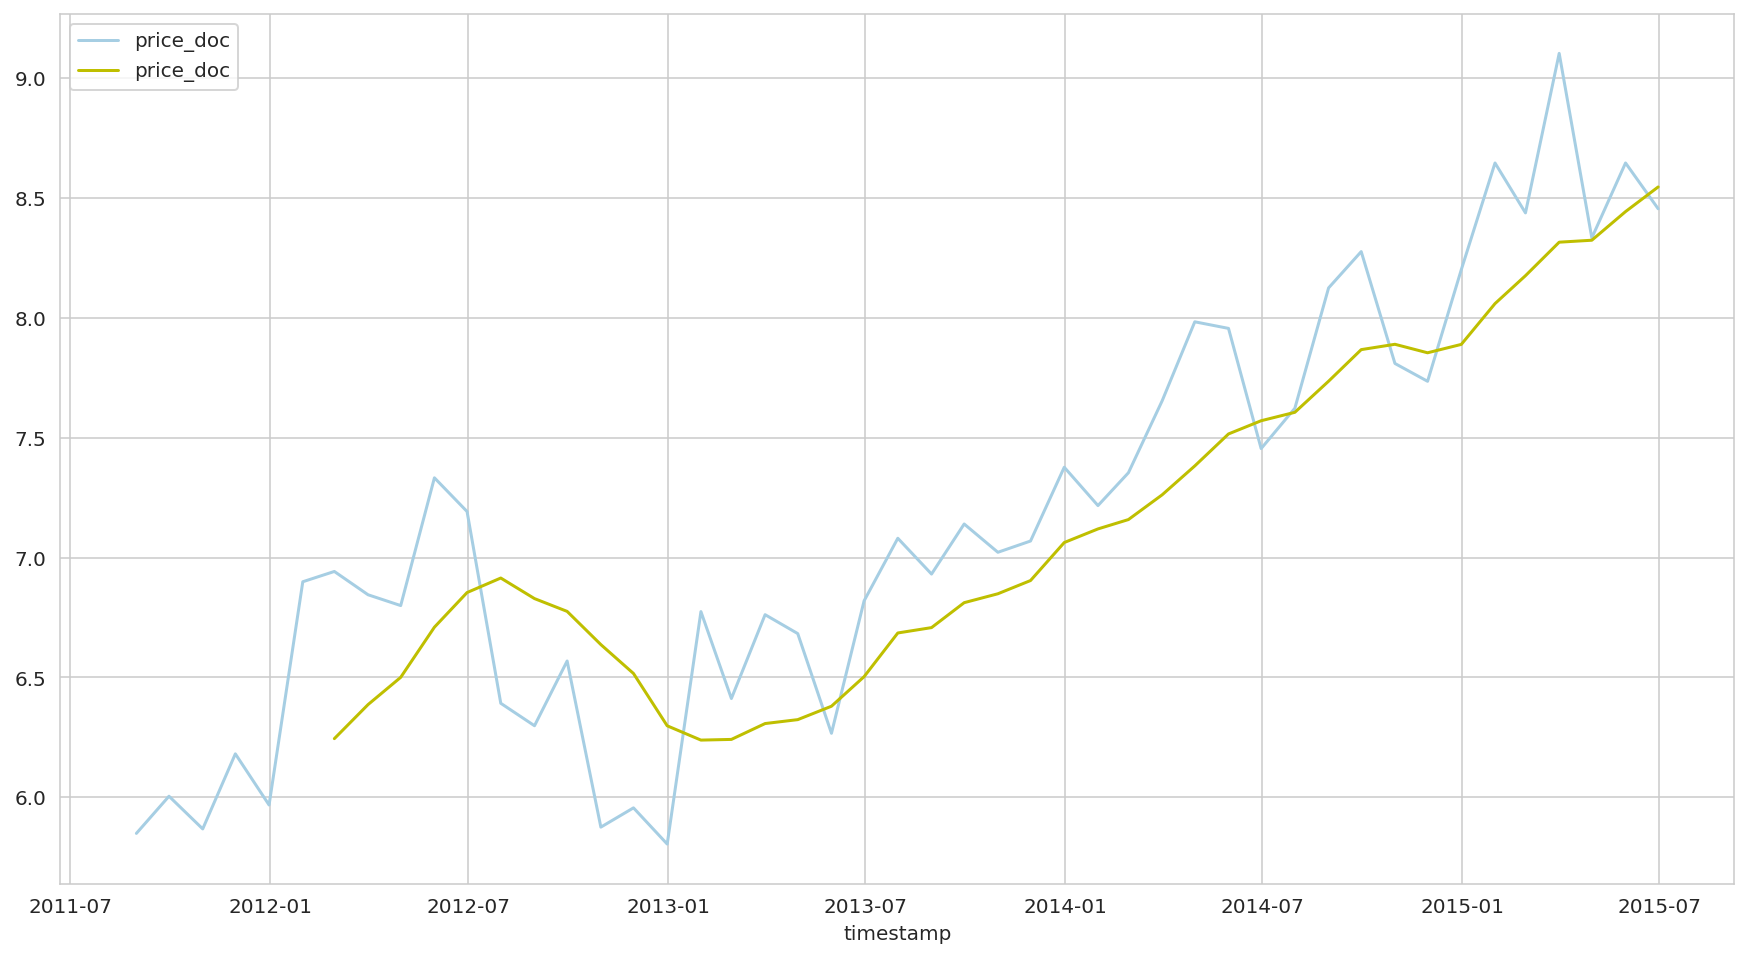

In [261]:
plt.figure(figsize=(15,8))

# Ресемплирование по месяцам
sns.lineplot(data=res)

# Недельная скользящая средняя
res_roll = res.rolling(7).mean()

sns.lineplot(data=res_roll, palette=['y'])

**Расширенный Тест Дики — Фуллера**

Проверим ряд на стационарность: 



In [262]:
prices = res['price_doc']
st_test = adfuller(prices, regression='ctt')

# Возьмем за P-Value 0.05 
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Наш ряд стационарный


Разложим наш временной ряд на составляющие:

In [263]:
decomposed = seasonal_decompose(res)

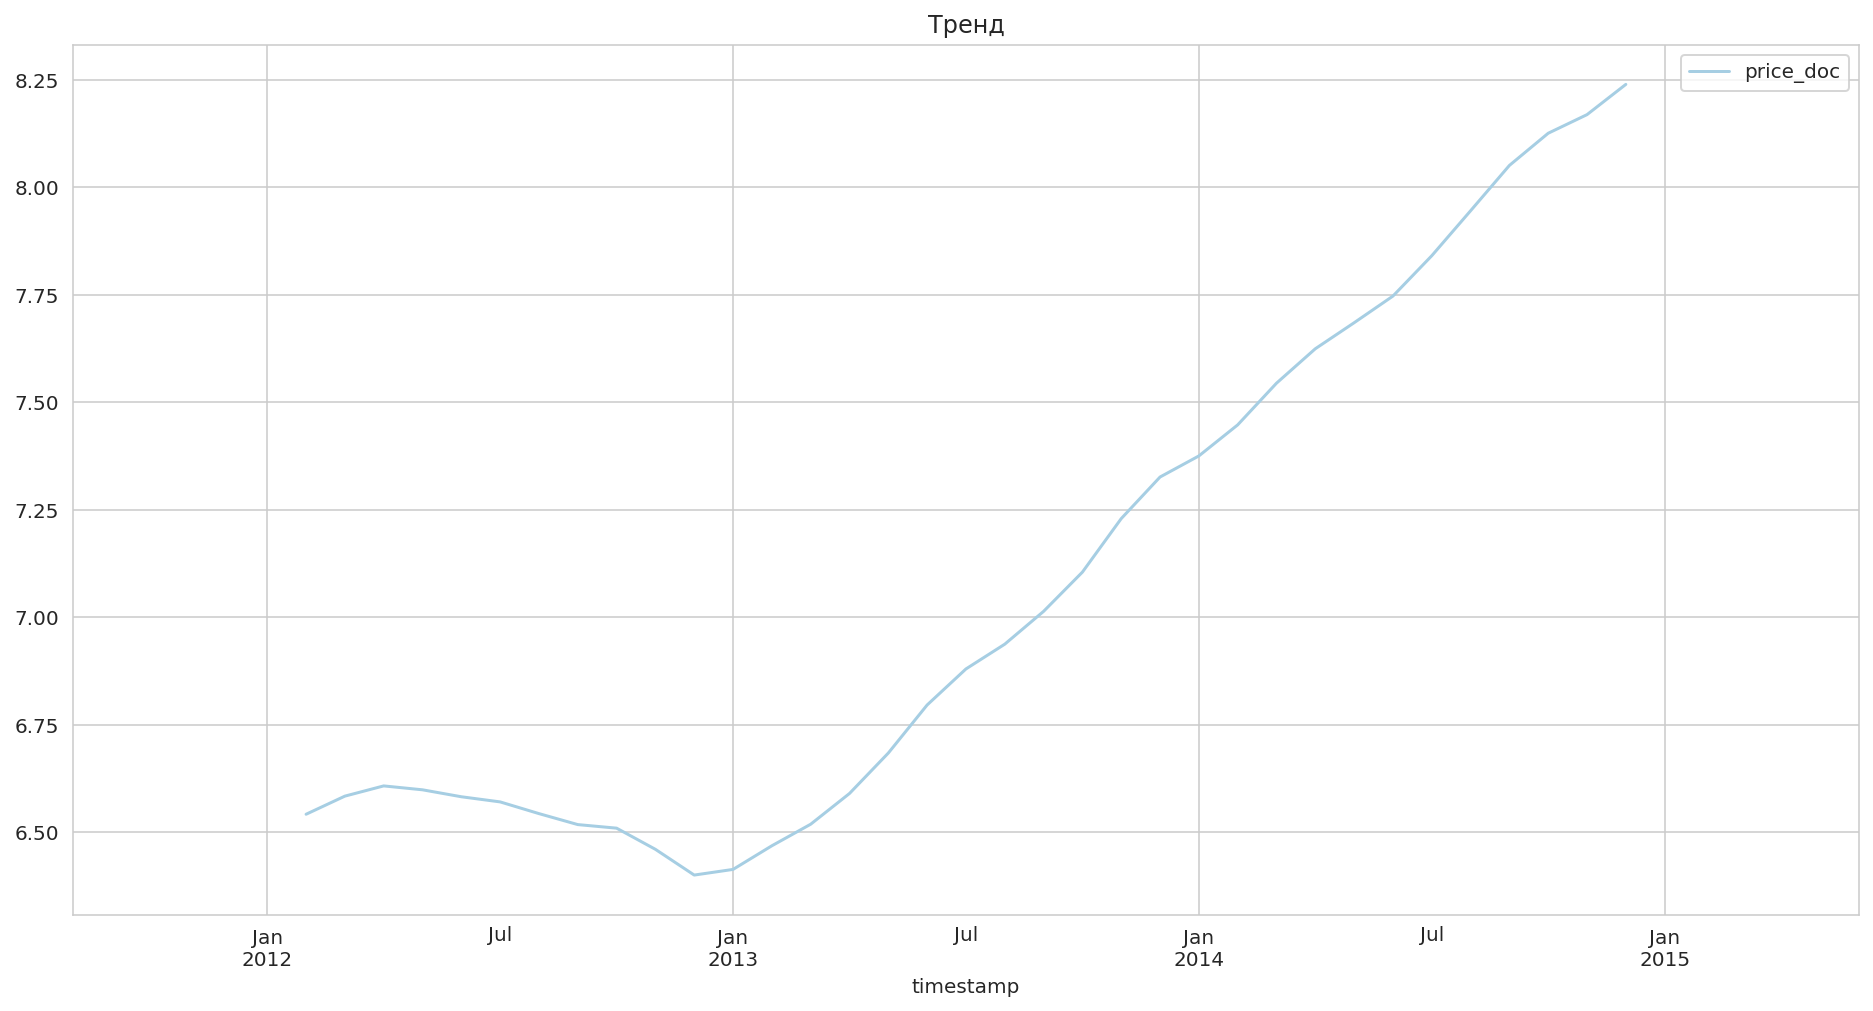

In [264]:
decomposed.trend.plot(title='Тренд', figsize=(16, 8))

В январе 2013 произошёл "бум" цен на квартиры

Для сезонной составляющей возьмем последние три года:

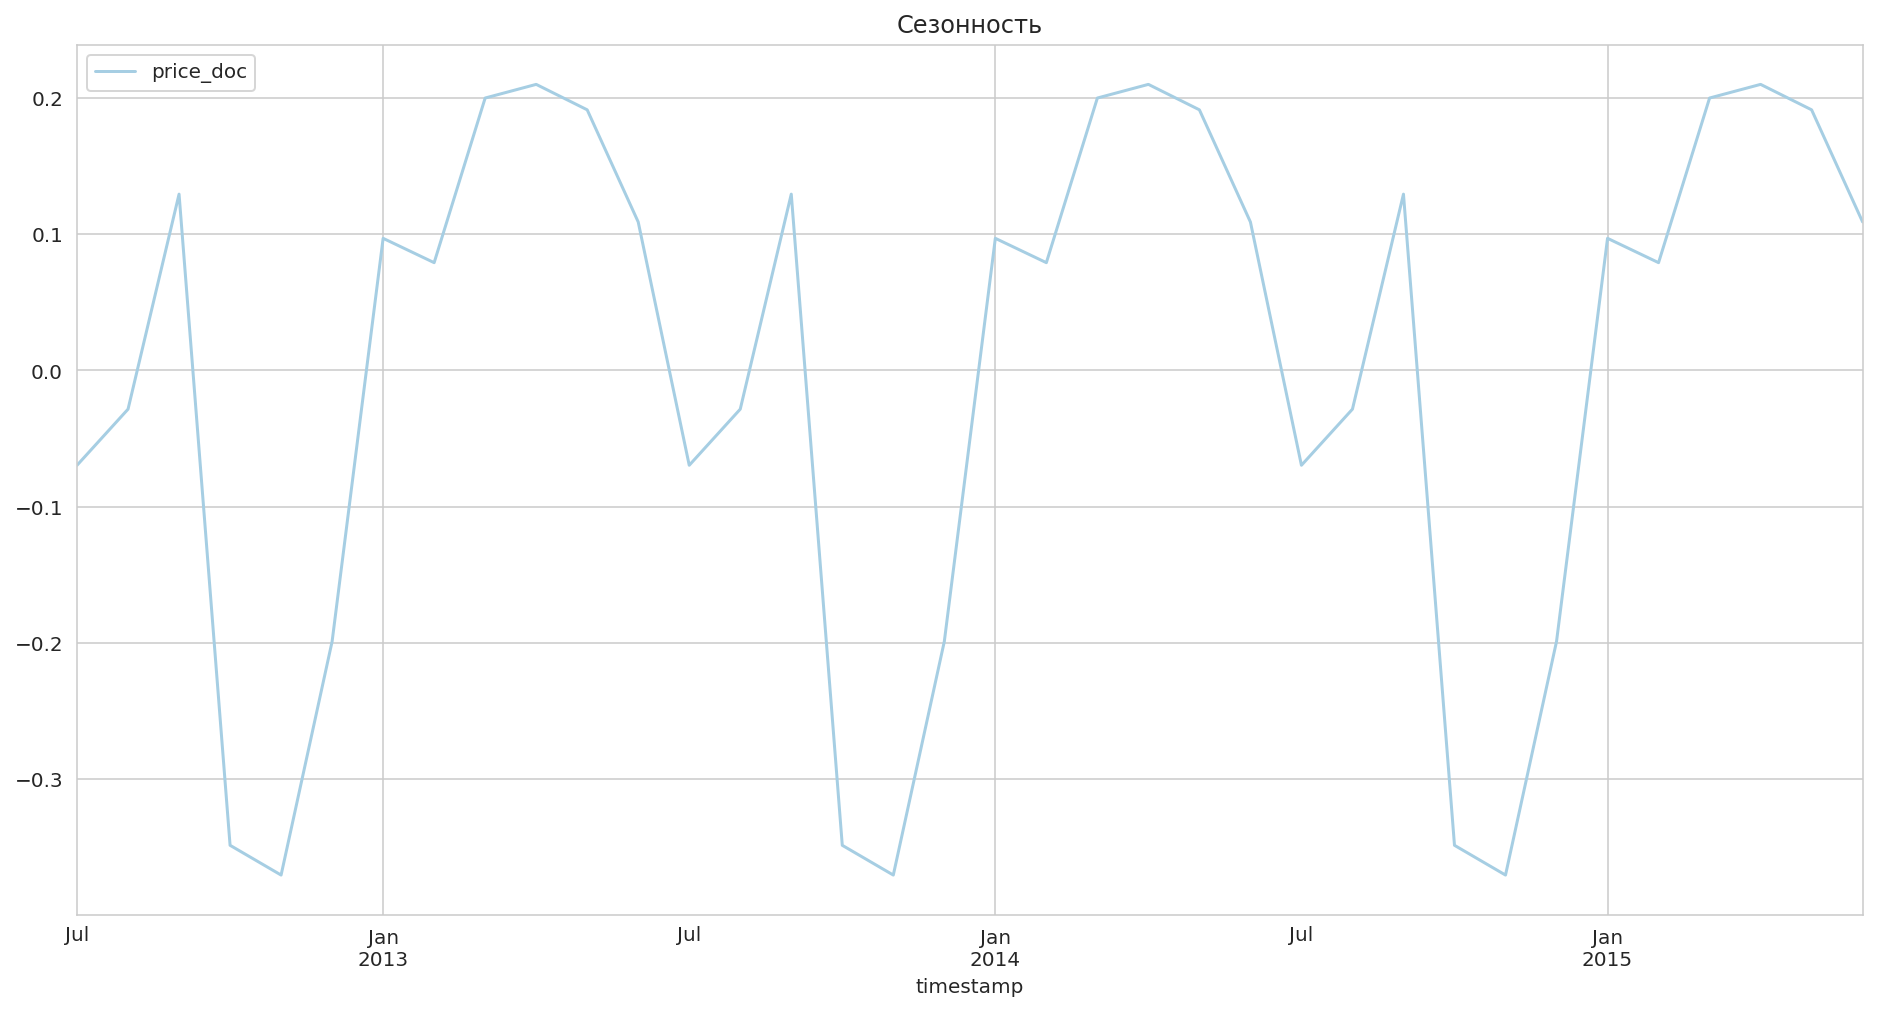

In [265]:
decomposed.seasonal.tail(12 * 3).plot(title='Сезонность', figsize=(16, 8))

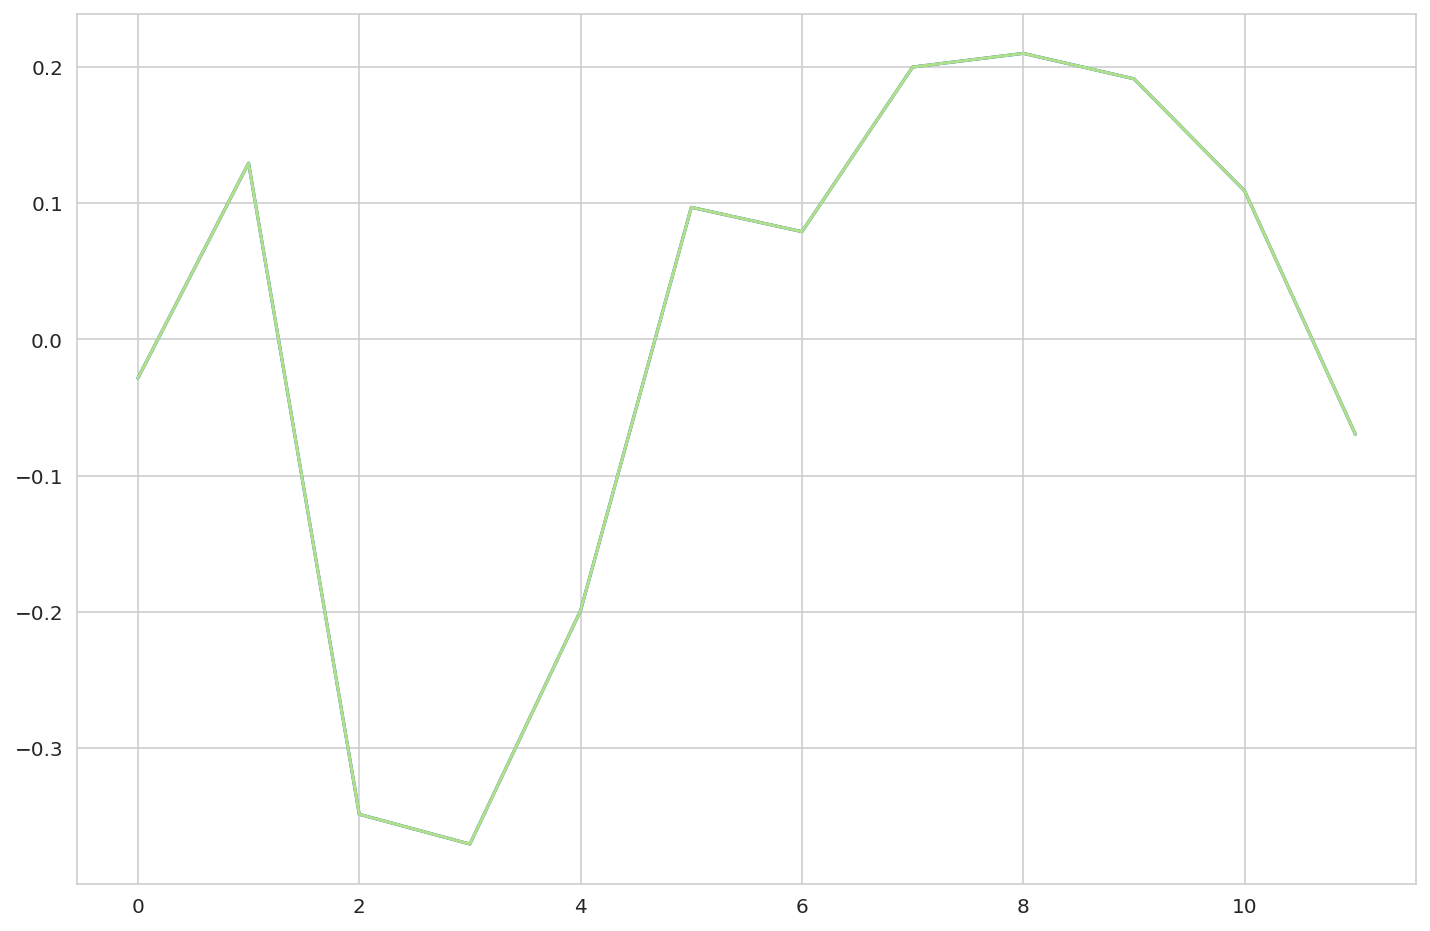

In [266]:
fig = plt.figure(figsize=(12, 8))
counter = 12
while counter < decomposed.seasonal.shape[0]:
    plt.plot(decomposed.seasonal[counter-12:counter].reset_index(drop=True), figure=fig)
    counter += 12

По данным блога [Домклик](https://blog.domclick.ru/post/v-kakoe-vremya-goda-vygodnee-pokupat-kvartiru) зимой спрос падаёт (" покупательская активность в это время года не самая высокая"), а осенью "конкуренция велика, а цены ей соответствуют". Похоже на правду

Признаки, связанные с площадью:
  * `full_sq` - полная площадь недвиж.
  * `life_sq` - жилая площадь
  * `kitch_sq` - площадь кухни
  
А также:
  * `build_year` - год постройки
           

In [267]:
sq_features = ['full_sq', 'life_sq', 'kitch_sq']

data[sq_features].head()

,full_sq,life_sq,kitch_sq
0,43,27.0000,NaN
1,34,19.0000,NaN
2,43,29.0000,NaN
3,89,50.0000,NaN
4,77,77.0000,NaN


In [268]:
data[sq_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27494 entries, 0 to 30470
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   full_sq   27494 non-null  int64  
 1   life_sq   22104 non-null  float64
 2   kitch_sq  18631 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.8 MB


In [269]:
data[sq_features].describe()

,full_sq,life_sq,kitch_sq
count,27494.0000,22104.0000,18631.0000
mean,54.1149,34.0616,6.4776
std,39.1507,54.0992,26.1416
min,0.0000,0.0000,0.0000
25%,38.0000,20.0000,1.0000
50%,49.0000,30.0000,6.0000
75%,63.0000,43.0000,9.0000
max,5326.0000,7478.0000,2014.0000


По данным компании **Blackwood** в настоящее время в Москве максимальная площадь квартиры, предлагаемой на первичном рынке элитных новостроек, составляет 830 кв

Удалим экстремально высокие значения, ограничив площадь, а также **невозможные значения** (`(kitch_sq + life_sq > full_sq)`)

In [270]:
wrong_data = len(data.query('(full_sq > 830) or (kitch_sq + life_sq > full_sq)'))

In [271]:
wrong_data / len(data) * 100

5.230232050629229

<10% данных будет удалено

In [272]:
data_sq = data.query('(full_sq <= 830) and (kitch_sq + life_sq <= full_sq)')
data_sq[sq_features].describe()

,full_sq,life_sq,kitch_sq
count,13817.0000,13817.0000,13817.0000
mean,52.7198,31.0982,7.2875
std,20.2581,15.3333,3.2067
min,0.0000,0.0000,0.0000
25%,38.0000,19.0000,5.0000
50%,47.0000,29.0000,7.0000
75%,62.0000,40.0000,9.0000
max,275.0000,232.0000,57.0000


Посмотрим boxplot'ы:

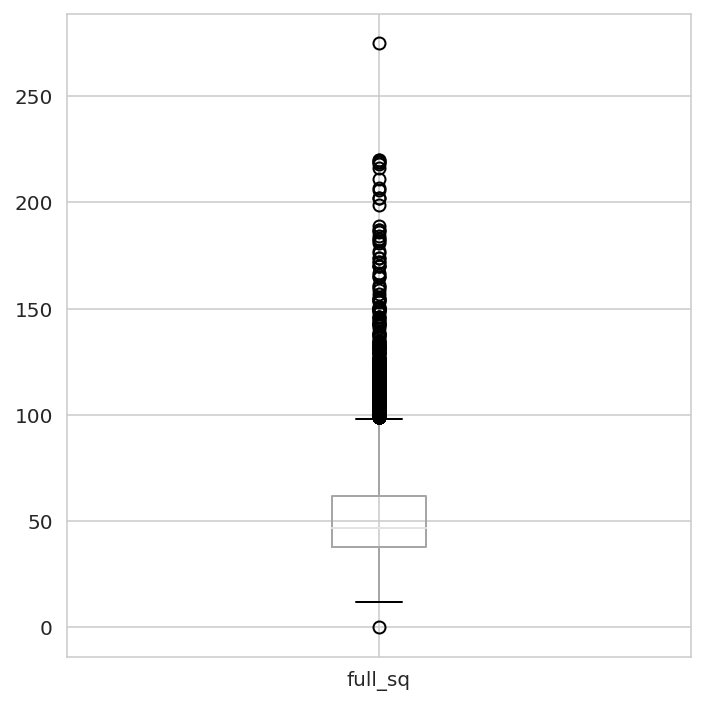

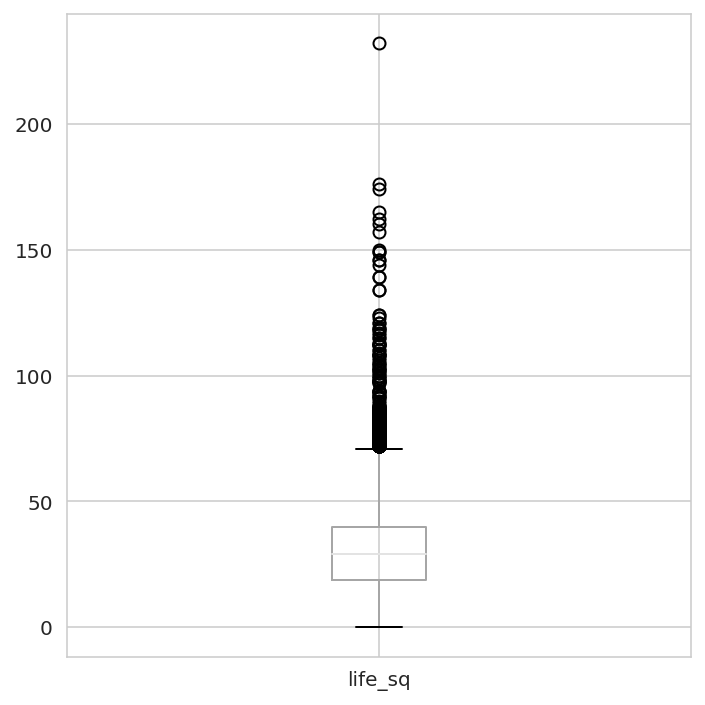

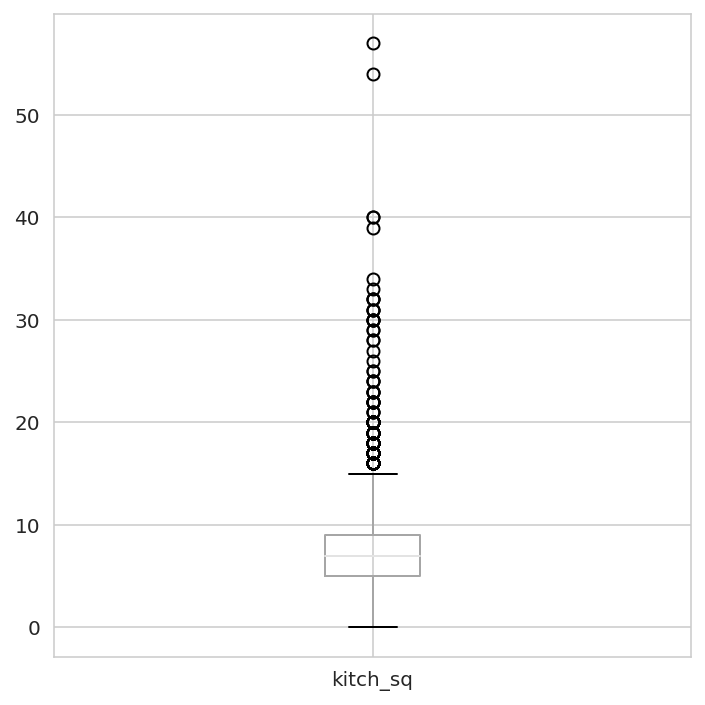

In [273]:
for col in sq_features:
    plt.figure(figsize=(5, 5), tight_layout=True)
    data_sq.boxplot(col)

Присутствует большое количество выбросов

Используем **Тест Граббса** для определения выбросов:

In [274]:
in_rows = grubbs.test(data_sq['full_sq'].values, alpha=0.05)

In [275]:
in_rows = data_sq.loc[data_sq['full_sq'].isin(in_rows)]

In [276]:
out_rows = data_sq.drop(in_rows.index, axis=0)

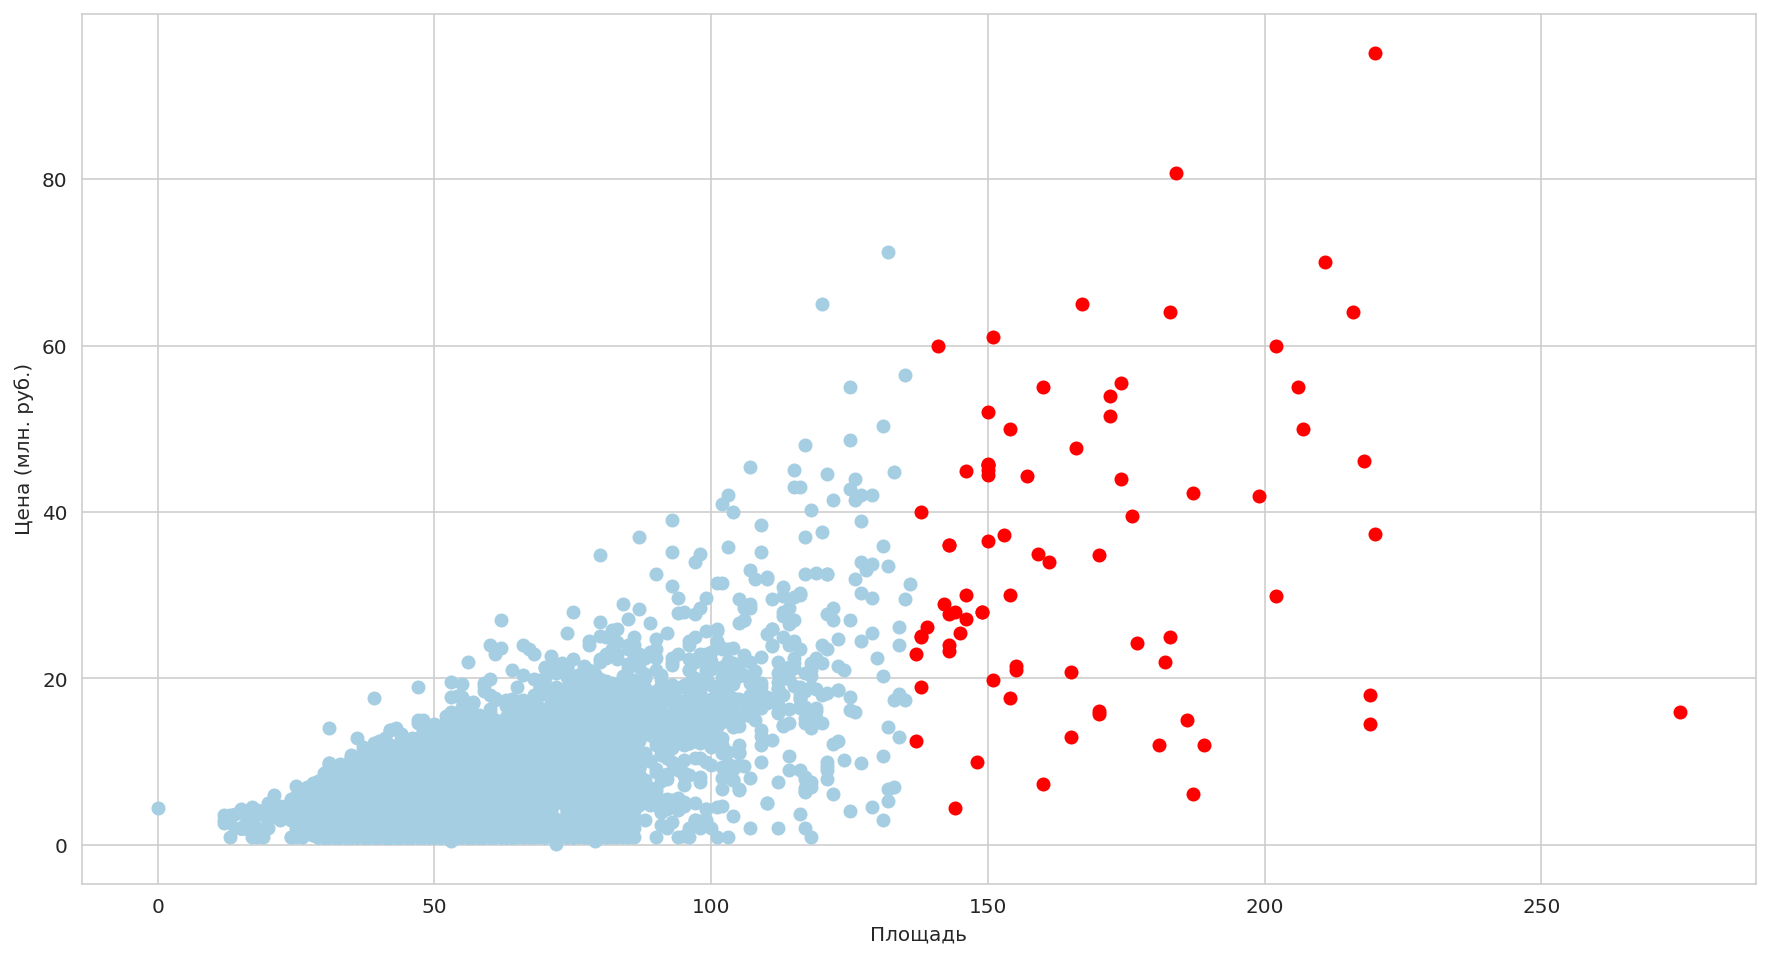

In [277]:
plt.figure(figsize=(15,8))

plt.xlabel('Площадь')
plt.ylabel('Цена (млн. руб.)')
plt.scatter(in_rows['full_sq'], in_rows['price_doc'])
plt.scatter(out_rows['full_sq'], out_rows['price_doc'], c='r')

In [278]:
in_rows.pivot_table(index='kremlin_km', values='full_sq', aggfunc=['mean', 'median', 'var', 'std'])

,mean,median,var,std
,full_sq,full_sq,full_sq,full_sq
kremlin_km,,,,
0.1000,66.2159,63.0000,612.7000,24.7528
0.6000,86.5000,86.5000,364.5000,19.0919
0.7000,90.0000,90.0000,NaN,NaN
0.8000,80.0000,80.0000,1352.0000,36.7696
0.9000,89.0000,89.0000,162.0000,12.7279
...,...,...,...,...
25.6000,59.9333,63.0000,361.1091,19.0029
25.7000,54.6875,57.0000,179.6237,13.4024


**Проверим гипотезу:** Площади квартир, которые построены в 21 веке  **не равны** площадям квартир, которые построены в 20 веке.

**H0** - Площадь квартиры в 21 веке не отличается ($=$) от площади в 20 веке

**H1** - Площадь квартир в 21 веке отличается ($\neq$) от площади в 20 веке

In [279]:
in_rows['build_year'].describe()

count      13454.0000
mean        3429.5499
std       172858.5143
min            0.0000
25%         1966.0000
50%         1976.0000
75%         1997.0000
max     20052009.0000
Name: build_year, dtype: float64

In [280]:
in_rows = in_rows.query('build_year > 1700 and build_year < 2017')

In [281]:
in_rows['build_year'].describe()

count   13086.0000
mean     1980.9610
std        19.0390
min      1860.0000
25%      1967.0000
50%      1976.0000
75%      1998.0000
max      2016.0000
Name: build_year, dtype: float64

In [282]:
sample_1 = in_rows.query("build_year > 1999")['full_sq']
sample_2 = in_rows.query("build_year <= 1999")['full_sq']
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

p-значение:  2.941868750787891e-270
Принимаем альтернативную гипотезу


In [283]:
in_rows['build_year'] = pd.to_datetime(in_rows['build_year'], format='%Y')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [284]:
in_rows['build_year'].head()

8135   1980-01-01
8153   2014-01-01
8154   1970-01-01
8175   1982-01-01
8255   2004-01-01
Name: build_year, dtype: datetime64[ns]

In [285]:
res = pd.DataFrame(in_rows['full_sq'])
res.index = in_rows['build_year']
res.head()

,full_sq
build_year,
1980-01-01,53
2014-01-01,77
1970-01-01,45
1982-01-01,38
2004-01-01,74


Ресемпл по 3 года

In [286]:
res = pd.DataFrame(res.resample('3Y').median()).dropna()
display(res.head())
print(res.shape)

,full_sq
build_year,
1860-12-31,33.5000
1878-12-31,50.0000
1890-12-31,55.0000
1896-12-31,53.0000
1902-12-31,106.0000


(42, 1)


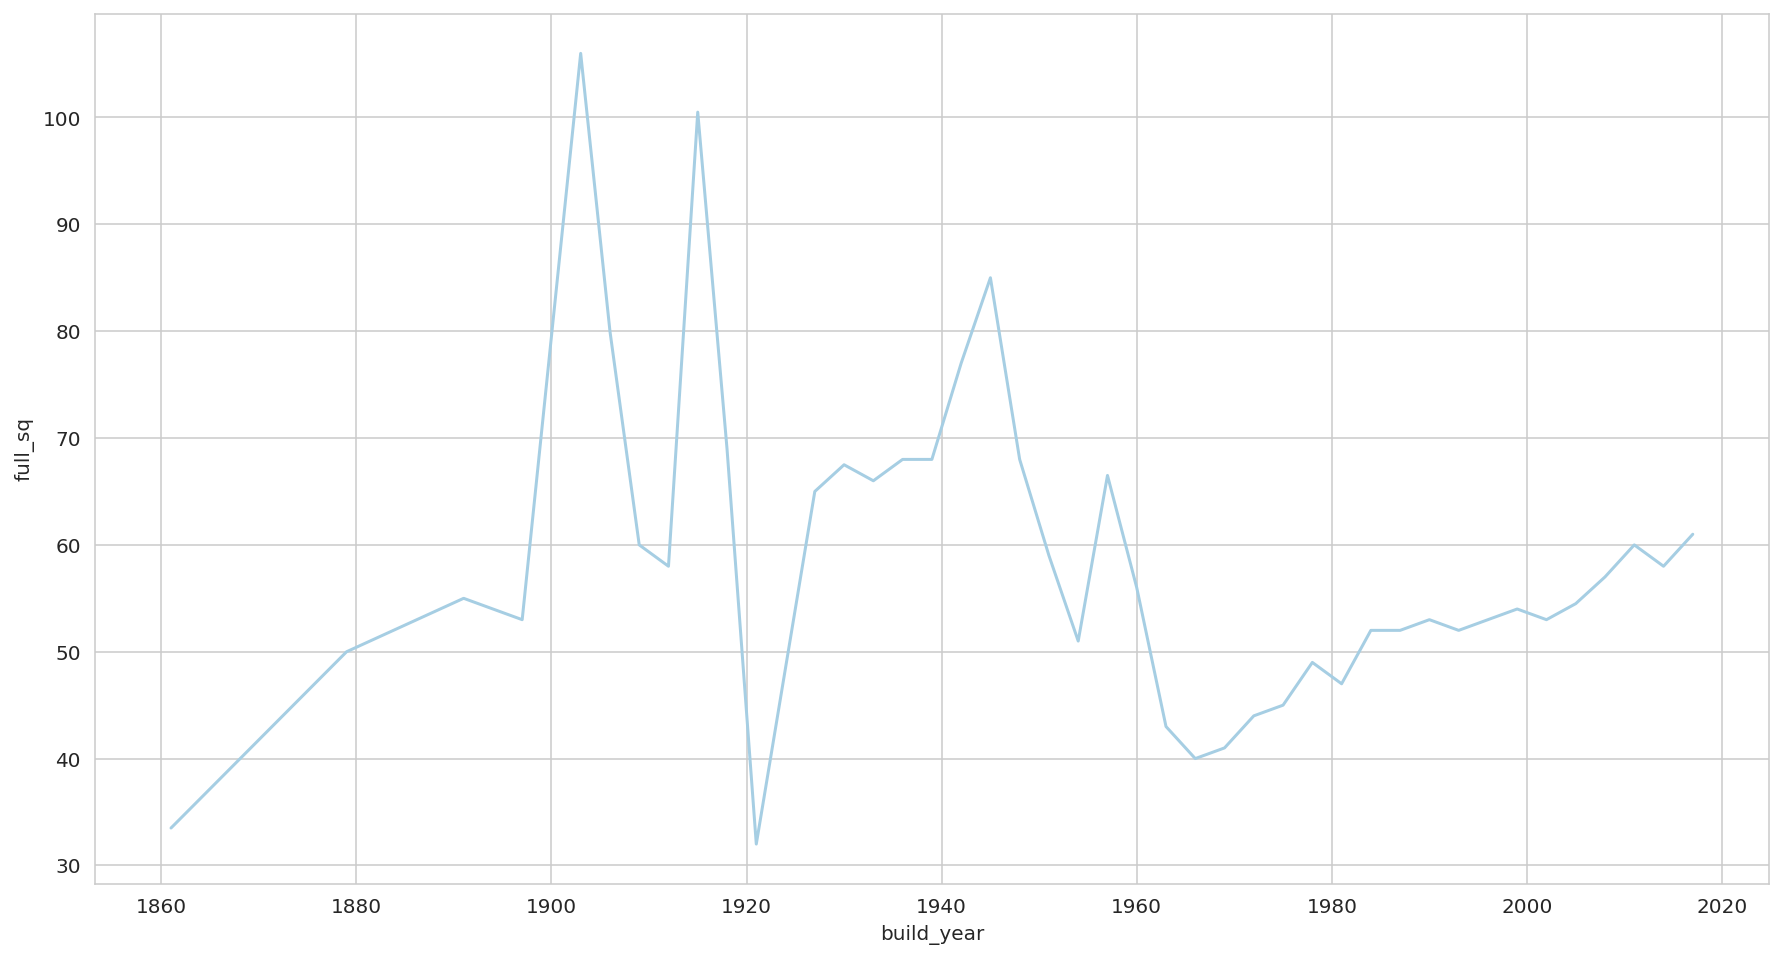

In [287]:
plt.figure(figsize=(15,8))

sns.lineplot(x='build_year', y='full_sq', data=res)

Альтернативная гипотеза на тех данных, что мы имеем, подтвердилась

Посмотрим, где самые старые и где самые новые дома (топ 5):

In [288]:
years_data = data.query('build_year > 1700 and build_year < 2018')
years_data_old = years_data.loc[years_data['build_year'] < years_data['build_year'].quantile(0.01)]
print(years_data_old.shape[0])

140


In [289]:
years_data_old.groupby('sub_area')['build_year'].mean().sort_values().head()

sub_area
Kuz'minki     1860.0000
Kotlovka      1910.0000
Lefortovo     1910.7500
Meshhanskoe   1914.2500
Arbat         1914.5000
Name: build_year, dtype: float64

In [290]:
years_data_new = years_data.loc[years_data['build_year'] > years_data['build_year'].quantile(0.95)]
print(years_data_new.shape[0])

426


In [291]:
years_data_new.groupby('sub_area')['build_year'].mean().sort_values(ascending=False).head()

sub_area
Taganskoe              2017.0000
Ramenki                2016.8750
Presnenskoe            2016.8000
Sviblovo               2016.7500
Prospekt Vernadskogo   2016.7500
Name: build_year, dtype: float64

Посмотрим на:
   * `floor` - этаж
   * `max_floor` - всего этажей
   * `material` - материал стен
   * `num_room` - количество жилых комнат
   * `state` - состояние квартиры

In [292]:
phy_features = ['floor', 'max_floor', 'material', 'num_room', 'state', 'price_doc', 'kremlin_km']

data[phy_features].head()

,floor,max_floor,material,num_room,state,price_doc,kremlin_km
0,4.0000,NaN,NaN,NaN,NaN,5.8500,15.2000
1,3.0000,NaN,NaN,NaN,NaN,6.0000,8.7000
2,2.0000,NaN,NaN,NaN,NaN,5.7000,9.1000
3,9.0000,NaN,NaN,NaN,NaN,13.1000,19.5000
4,4.0000,NaN,NaN,NaN,NaN,16.3315,2.6000


In [293]:
data[phy_features].isna().mean() * 100

floor         0.4510
max_floor    32.2361
material     32.2361
num_room     32.2361
state        44.2969
price_doc     0.0000
kremlin_km    0.0000
dtype: float64

In [294]:
data[phy_features].describe()

,floor,max_floor,material,num_room,state,price_doc,kremlin_km
count,27370.0000,18631.0000,18631.0000,18631.0000,15315.0000,27494.0000,27494.0000
mean,7.7919,12.7729,1.8090,1.9254,2.1508,7.3922,14.1500
std,5.3808,6.7239,1.4528,0.8543,0.8677,4.9108,6.0240
min,0.0000,0.0000,1.0000,0.0000,1.0000,0.1000,0.1000
25%,3.0000,9.0000,1.0000,1.0000,1.0000,5.0000,9.9000
50%,7.0000,12.0000,1.0000,2.0000,2.0000,6.4500,13.8000
75%,11.0000,17.0000,2.0000,3.0000,3.0000,8.5000,19.5000
max,77.0000,117.0000,6.0000,19.0000,33.0000,111.1111,26.0000


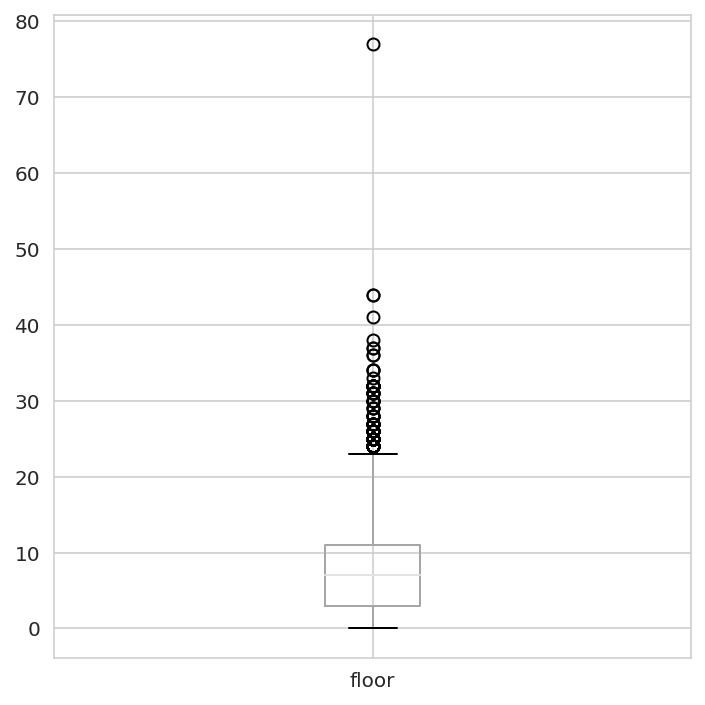

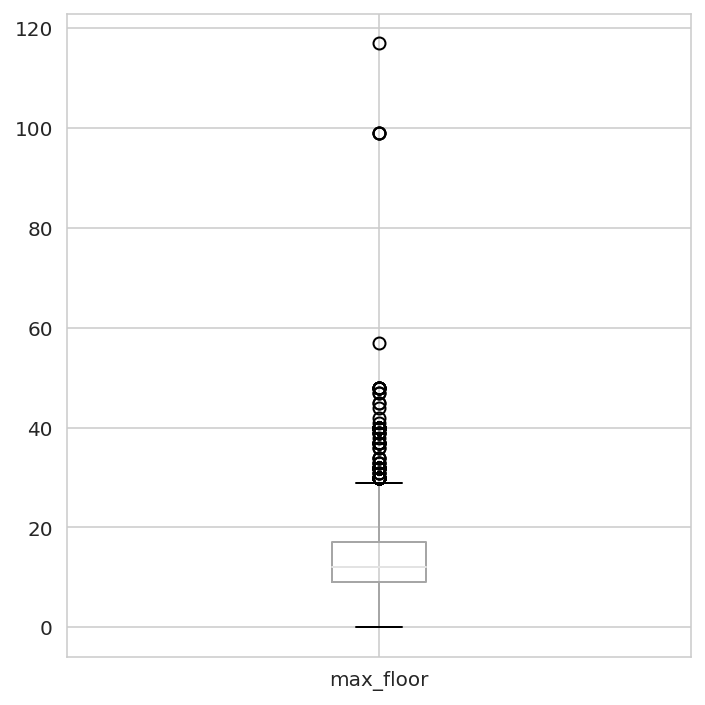

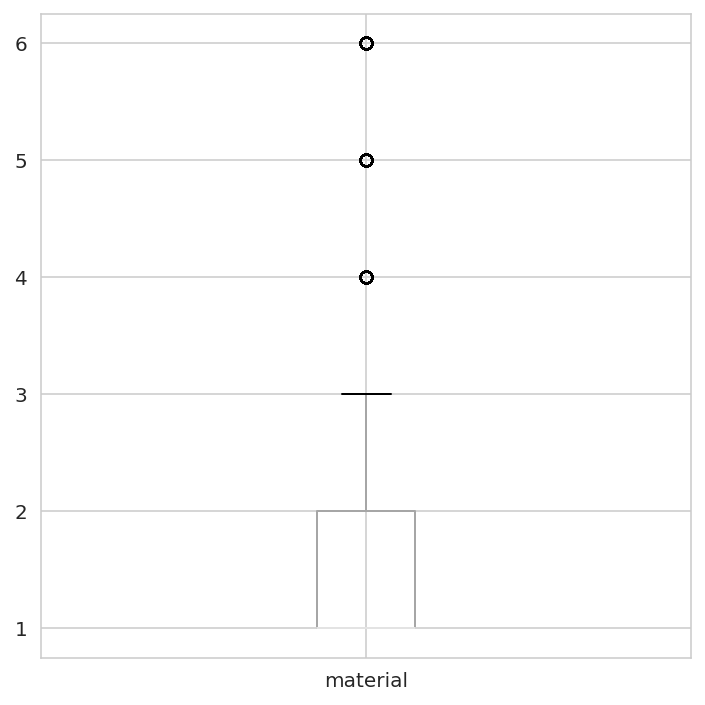

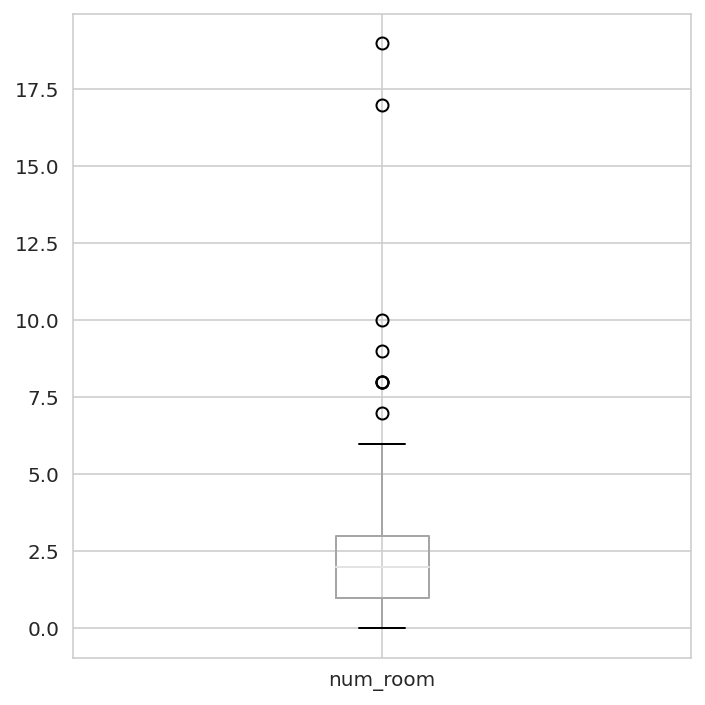

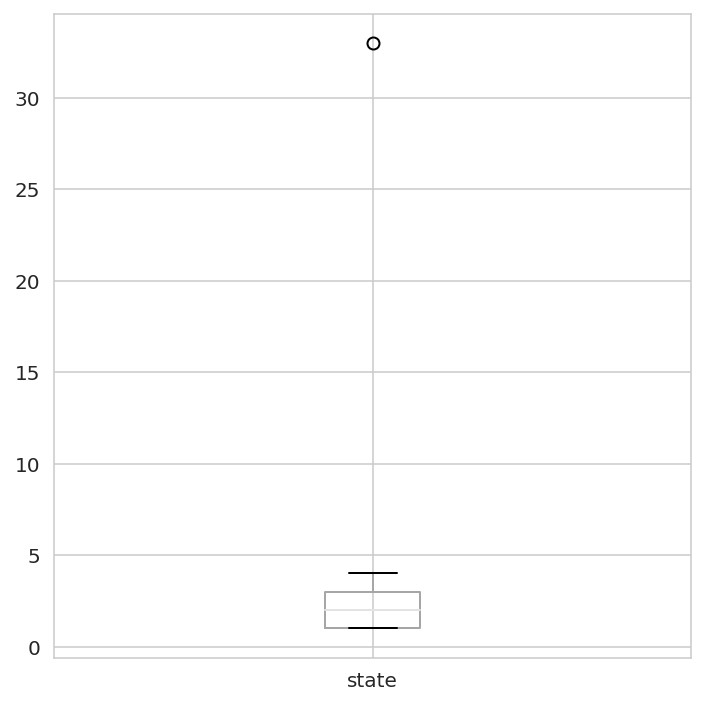

In [295]:
for col in phy_features[:5]:
    plt.figure(figsize=(5, 5), tight_layout=True)
    data.boxplot(col)

In [296]:
data[phy_features].loc[data['floor'] == 77.0000]

,floor,max_floor,material,num_room,state,price_doc,kremlin_km
23584,77.0000,22.0000,1.0000,2.0000,3.0000,13.7000,9.9000


`max_floor` < `floor`, чего быть не может.

In [297]:
data[phy_features].loc[data['floor'] > data['max_floor']].shape

(1175, 7)

In [298]:
data[phy_features].loc[data['max_floor'] == 117.0000]

,floor,max_floor,material,num_room,state,price_doc,kremlin_km
25940,8.0000,117.0000,1.0000,2.0000,1.0000,7.2398,0.1000


Либо здание находится дальше 100 метров от центра, либо этажей явно не 117

Посмотрим на:
  * `sub_area` - название района

In [299]:
data['sub_area'].sort_values().unique()

array(['Ajeroport', 'Akademicheskoe', 'Alekseevskoe', "Altuf'evskoe",
       'Arbat', 'Babushkinskoe', 'Basmannoe', 'Begovoe',
       'Beskudnikovskoe', 'Bibirevo', 'Birjulevo Vostochnoe',
       'Birjulevo Zapadnoe', 'Bogorodskoe', 'Brateevo', 'Butyrskoe',
       'Caricyno', 'Cheremushki', "Chertanovo Central'noe",
       'Chertanovo Juzhnoe', 'Chertanovo Severnoe', 'Danilovskoe',
       'Dmitrovskoe', 'Donskoe', 'Dorogomilovo', 'Filevskij Park',
       'Fili Davydkovo', 'Gagarinskoe', "Gol'janovo", 'Golovinskoe',
       'Hamovniki', 'Horoshevo-Mnevniki', 'Horoshevskoe', 'Hovrino',
       'Ivanovskoe', 'Izmajlovo', 'Jakimanka', 'Jaroslavskoe', 'Jasenevo',
       'Juzhnoe Butovo', 'Juzhnoe Medvedkovo', 'Juzhnoe Tushino',
       'Juzhnoportovoe', 'Kapotnja', "Kon'kovo", 'Koptevo',
       'Kosino-Uhtomskoe', 'Kotlovka', "Krasnosel'skoe", 'Krylatskoe',
       'Kuncevo', 'Kurkino', "Kuz'minki", 'Lefortovo', 'Levoberezhnoe',
       'Lianozovo', 'Ljublino', 'Lomonosovskoe', 'Losinoostrovskoe

Самые дорогие и самые дешёвые районы города:

In [300]:
prices = data.groupby(['sub_area'])['price_doc'].median().sort_values()

In [301]:
prices.head()

sub_area
Poselenie Filimonkovskoe   0.9900
Poselenie Shherbinka       3.6000
Vnukovo                    4.8000
Vostochnoe                 4.8000
Zapadnoe Degunino          4.9611
Name: price_doc, dtype: float64

In [302]:
prices.tail()

sub_area
Obruchevskoe     12.5000
Zamoskvorech'e   12.7500
Lomonosovskoe    13.5000
Kurkino          13.9300
Hamovniki        15.6250
Name: price_doc, dtype: float64

<a name='c5'></a>
# Итоги обзора:
  * Были изучены признаки, выбросы и способы борьбы с ними
  * Найдены *ошибочные* значения в признаках
  * Изучена корреляция между признаками, проверены с помощью тестов гипотезы
  * Найдены факторы, наиболее влияющие на цену